<a href="https://colab.research.google.com/github/appaniakhil/fifa-players-market-value-prediction/blob/main/fifa_players_market_value_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1  Descrption

#### | summary |

In the project, I use a dataset from the game FIFA21, that contains data of ca. 17.000 football players, listing a variety of information for them, such as club, wage, different scores for their skills and many more.

#### | objectives |

The objective is to build a linear regression model that predicts the players market value as accurate as possible. Moreover I want to answer the following 3 questions:

1. How much does the prediction quality vary in to the value? 
E.g. is there a trend of the model getting worse the highger the value is?
2. Which field position has the highest average value?
3.   How many players have a maximum overall score?

# 2 Setup 

In [ ]:
pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### | library imports |

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import random 
import seaborn as sns
import os
import math
import random
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.set_option('max_row', None)


##### | Data import / overview |

In [ ]:
data = pd.read_csv('/content/fifa.csv')
data.head()

FileNotFoundError: ignored

In [ ]:
data.shape

(17125, 107)

In [ ]:
data.dtypes

ID                    int64
Name                 object
Age                   int64
OVA                   int64
Nationality          object
Club                 object
BOV                   int64
BP                   object
Position             object
Player Photo         object
Club Logo            object
Flag Photo           object
POT                   int64
Team & Contract      object
Height               object
Weight               object
foot                 object
Growth                int64
Joined               object
Loan Date End        object
Value                object
Wage                 object
Release Clause       object
Contract             object
Attacking             int64
Crossing              int64
Finishing             int64
Heading Accuracy      int64
Short Passing         int64
Volleys             float64
Skill                 int64
Dribbling             int64
Curve               float64
FK Accuracy           int64
Long Passing          int64
Ball Control        

In [ ]:
# check if column id is ready to be used as index column

data['ID'].nunique()


17125

# 3 Cleaning/Wrangling

#### | clean column names | 

In [ ]:
data.rename(columns={'W/F':'r_weakfoot', 'A/W':'r_attacking_work', 'D/W':'r_defensive_work', 'IR':'r_intr', 'SM':'r_skillmove'}, inplace=True)

def clean_headers(df):
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    return df

In [ ]:
clean_headers(data)

data.columns

Index(['id', 'name', 'age', 'ova', 'nationality', 'club', 'bov', 'bp',
       'position', 'player_photo',
       ...
       'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'gender'],
      dtype='object', length=107)

#### | Drop columns |

In [ ]:
# drop unnecessary columns

data = data.drop(['player_photo','club_logo','flag_photo', 'gender'], axis=1)

In [ ]:
data['loan_date_end'].count()

910

In [ ]:
data[~data['loan_date_end'].isnull()].head()

,id,name,age,ova,nationality,club,bov,bp,position,pot,team_&_contract,height,weight,foot,growth,joined,loan_date_end,value,wage,release_clause,contract,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats,r_weakfoot,r_skillmove,r_attacking_work,r_defensive_work,r_intr,pac,sho,pas,dri,def,phy,hits,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
174,34824,A. Floro Flores,34,72,Italy,Chievo Verona,67,CAM,NaN,72,"Bari Jun 30, 2018 On Loan","6'0""",172lbs,Right,0,"Jul 1, 2016","Jun 30, 2018",€400K,€6K,€0,"Bari Jun 30, 2018 On Loan",343,66,72,69,68,68.0,354,73,74.0,76,56,75,363,76,74,73.0,68,72.0,348,68,80.0,70,62,68,306,60,26.0,78.0,68.0,74,76.0,74,20,30,24.0,46,5,10,9,15,7,1834,381,3 ★,3★,High,Low,2 ★,75,71,67,73,30,65,3,67+1,67+1,67+1,66+0,67+0,67+0,67+0,66+0,66+1,66+1,66+1,64+1,61+1,61+1,61+1,64+1,50+1,51+1,51+1,51+1,50+1,48+1,49+1,49+1,49+1,48+1,15+1
179,39943,J. Park,32,78,Korea Republic,PSV,77,CAM,CAM RW,78,"PSV Jun 30, 2014 On Loan","5'10""",161lbs,Right,0,"Jul 1, 2012","Jun 30, 2014",€4.1M,€80K,€0,"Jun 30, 2014 On Loan",359,70,70,68,79,72.0,339,78,65.0,53,64,79,395,77,76,82.0,82,78.0,322,72,44.0,86,59,61,328,42,55.0,81.0,76.0,74,NaN,130,45,52,33.0,50,6,15,6,14,9,1923,408,3 ★,3★,High,High,3 ★,76,69,72,79,50,62,6,74+1,74+1,74+1,76+1,75+1,75+1,75+1,76+1,77+1,77+1,77+1,77+1,73+1,73+1,73+1,77+1,66+1,66+1,66+1,66+1,66+1,61+1,54+1,54+1,54+1,61+1,15+1
230,50598,D. Bent,33,70,England,Burton Albion,69,ST,ST,70,"Burton Albion Jun 30, 2018 On Loan","5'11""",161lbs,Right,0,"Jul 1, 2015","Jun 30, 2018",€1.1M,€10K,€0,"Jun 30, 2018 On Loan",325,54,72,71,57,71.0,285,61,68.0,58,31,67,335,68,65,73.0,64,65.0,331,75,77.0,45,69,65,265,43,23.0,74.0,50.0,75,79.0,60,21,19,20.0,44,8,9,13,6,8,1645,337,3 ★,3★,Low,Low,2 ★,66,71,52,64,26,58,7,69+1,69+1,69+1,64+0,65+0,65+0,65+0,64+0,62+1,62+1,62+1,60+1,52+1,52+1,52+1,60+1,44+1,40+1,40+1,40+1,44+1,42+1,41+1,41+1,41+1,42+1,14+1
329,111590,L. FeeneyB,33,65,England,Tranmere Rovers,66,RM,NaN,65,"Tranmere Rovers Jun 30, 2021 On Loan","6'0""",168lbs,Right,0,"Aug 23, 2018","Jun 30, 2021",€240K,€3K,€0,"Jun 30, 2021 On Loan",293,72,53,47,63,58.0,311,67,67.0,53,60,64,359,75,78,75.0,61,70.0,320,63,54.0,75,68,60,275,49,54.0,61.0,60.0,51,56.0,160,50,56,54.0,50,12,8,10,12,8,1768,382,3 ★,3★,High,Low,1 ★,77,57,63,67,53,65,3,61+2,61+2,61+2,65+0,63+0,63+0,63+0,65+0,63+2,63+2,63+2,66+-1,62+2,62+2,62+2,66+-1,63+2,59+2,59+2,59+2,63+2,62+2,56+2,56+2,56+2,62+2,16+2
486,140038,J. Rodríguez,37,67,Mexico,Monarcas Morelia,67,CM,CDM CM,67,"Monarcas Morelia Jun 30, 2018 On Loan","5'5""",150lbs,Right,0,"Dec 17, 2014","Jun 30, 2018",€50K,€5K,€0,"Jun 30, 2018 On Loan",299,68,51,43,69,68.0,349,62,75.0,75,68,69,283,42,34,63.0,67,77.0,330,76,53.0,60,66,75,345,67,66.0,60.0,68.0,84,69.0,189,65,67,57.0,57,15,7,11,9,15,1852,363,4 ★,2★,Medium,Medium,1 ★,38,64,69,65,63,64,4,59+1,59+1,59+1,61+0,62+0,62+0,62+0,61+0,64+1,64+1,64+1,61+1,67+0,67+0,67+0,61+1,62+1,66+1,66+1,66+1,62+1,61+1,62+1,62+1,62+1,61+1,18+1


In [ ]:
data.dtypes

name                object
age                  int64
ova                  int64
nationality         object
club                object
bov                  int64
bp                  object
position            object
pot                  int64
height               int64
weight               int64
foot                object
growth               int64
joined               int64
value                int64
wage                 int64
release_clause       int64
contract             int64
attacking            int64
crossing             int64
finishing            int64
heading_accuracy     int64
short_passing        int64
volleys              int64
skill                int64
dribbling            int64
curve                int64
fk_accuracy          int64
long_passing         int64
ball_control         int64
movement             int64
acceleration         int64
sprint_speed         int64
agility              int64
reactions            int64
balance              int64
power                int64
s

In [ ]:
data.position.value_counts()


cb               1988
st               1714
gk               1466
cdm_cm            701
cm                641
lb                607
cm_cdm            559
rb                507
cdm               260
cam               253
lm                221
cam_cm            219
rm                198
cb_rb             197
rm_lm             188
cb_cdm            182
cb_lb             179
lm_rm             179
cm_cam            169
lb_lm             152
rw                111
rb_lb             111
rb_cb             102
rb_rm             101
lb_lwb            100
lw                 91
cdm_cb             91
rb_rwb             85
lw_rw              84
lb_cb              82
st_lw              81
rw_lw              78
st_lm              78
st_cam             77
st_rm              76
cm_cdm_cam         76
st_rw              76
cam_rm             70
cam_lm             62
lm_st              62
rm_rw              62
rm_st              57
cam_st             55
lm_cam             54
st_cf              53
rm_cam    

-> the ratio of players, that are loaned to another team is very low. The column is not going to be helpful to create a model.

-> The column 'team_&_contract' is redundant because it doesn't contain any information that is not already present in other columns

In [ ]:

data = data.drop(['team_&_contract','loan_date_end'], axis=1)

#### | indexing |

In [ ]:
data = data.set_index('id')
data = data.reset_index(drop=True)

#### | cleaning |
parametrization of cathegorical columns
and cleaning columns to prepare some for conversions to numerical columns

In [ ]:
cat_select = ['nationality', 'club', 'bp', 'position', 'foot', 'r_attacking_work', 'r_defensive_work']

for column in cat_select:
    print(column, data[column].unique())

nationality ['Italy' 'Spain' 'England' 'Trinidad &amp; Tobago' 'Germany' 'Turkey'
 'Wales' 'Republic of Ireland' 'Nigeria' 'Brazil' 'Australia' 'Hungary'
 'Argentina' 'Portugal' 'Netherlands' 'France' 'Norway' 'Tunisia'
 'Bulgaria' 'Poland' 'United States' 'Mali' 'Finland' 'Iceland'
 'Czech Republic' 'Serbia' 'Sweden' 'Georgia' 'Denmark' 'Senegal' 'Israel'
 'Cameroon' 'Greece' 'Scotland' 'Ukraine' 'China PR' 'Colombia' 'Belgium'
 'Ivory Coast' 'Switzerland' 'Canada' 'Chile' 'Peru' 'Paraguay' 'Mexico'
 'Japan' 'Ghana' 'Korea Republic' 'Belarus' 'Egypt' 'Congo' 'Uruguay'
 'South Africa' 'Northern Ireland' 'Togo' 'Jamaica' 'Austria' 'Algeria'
 'Morocco' 'Albania' 'North Macedonia' 'Slovenia' 'Madagascar' 'Croatia'
 'Kosovo' 'Estonia' 'Moldova' 'Bosnia Herzegovina' 'Russia' 'Romania'
 'DR Congo' 'Antigua &amp; Barbuda' 'Burkina Faso' 'Panama' 'Gibraltar'
 'Venezuela' 'Benin' 'Cyprus' 'Iran' 'Haiti' 'Slovakia' 'Ecuador'
 'Saudi Arabia' 'Guinea' 'New Zealand' 'Latvia' 'Honduras' 'Gabon' 'Ken

In [ ]:
pip install numpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [ ]:
col_cat = list(data.select_dtypes(include=[object]).columns.values)
col_num = list(data.select_dtypes(include=[np.number]).columns.values)
col_money = ['value', 'wage', 'release_clause']
col_ratings = ['r_weakfoot', 'r_skillmove', 'r_intr']
pos_score = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']

# initial cleaning

def first_clean(df, columns=col_cat, skip_columns=[]):
    for column in columns:
        if column not in skip_columns:
            df[column] = df[column].str.strip().str.lower().str.replace(' ','_')
    return df

data = first_clean(data, skip_columns=['name', 'contract', 'joined'])


| cleaning of individual columns and conversion |

In [ ]:
data['nationality'] = data['nationality'].str.replace('&amp;','').str.replace('__','_').str.replace('___','_')

data['height'] = data['height'].str.replace('"','')
data['height'] = data['height'].apply(lambda x: round(int(x.split("'")[0])*30.48 + int(x.split("'")[1])*2.54))

data['weight'] = data['weight'].str.replace('lbs','')

# converting contract to contract duration so 'joined' and 'contract' are not redundant and the duration might be relevant. 
# Toms reasoning regarding contract end is a good alternative 

data['joined'] = pd.to_datetime(data['joined'])
data['joined'] = data['joined'].dt.strftime('%Y')

def contract_to_num(x):
    years = [int(i) for i in x.split() if i.isdigit()]
    if (('loan') not in str(x).lower()):
        if len(years) == 2:
            x = years[1] - years[0]
            return int(x)
        elif len(years) == 1:
            x = 1
            return int(x)
        else:
            return np.NaN
    else:
        return np.NaN

data['contract'] = data['contract'].apply(contract_to_num)

| cleaning columns in bulk and converting to numerical values |

In [ ]:
def money_to_num(x):
    # columns value, wage, release_clause
    x = str(x).replace('€','')
    if (('m') in str(x).lower()):
        x = x.replace('m','')
        x = int(round(float(x)*1000000))
        return x
    elif (('k') in str(x).lower()):
        x = x.replace('k','')
        x = int(round(float(x)*1000))
        return x
    else:
        return int(round(float(x)))
    
def ratings_to_num(x):
    # columns r_weakfoot, r_skillmove, r_intr
    x = int(str(x).replace('★','').replace('_',''))
    return int(x)

def score_to_num(x):
    # columns with positional scores
    x = str(x).replace('+-','-')
    if ('+') in x:
        x = int(x.split('+')[0]) + int(x.split('+')[1])
    elif ('-') in x:
        x = int(x.split('-')[1]) + int(x.split('-')[0])
    else:
        x = int(x)
    return x

for column in col_money:
    data[column] = data[column].apply(money_to_num)
    
for column in col_ratings:
    data[column] = data[column].apply(ratings_to_num)
    
for column in pos_score:
    data[column] = data[column].apply(score_to_num)

In [ ]:
data.head()

,name,age,ova,nationality,club,bov,bp,position,pot,height,weight,foot,growth,joined,value,wage,release_clause,contract,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats,r_weakfoot,r_skillmove,r_attacking_work,r_defensive_work,r_intr,pac,sho,pas,dri,def,phy,hits,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,G. Pasquale,33,69,italy,udinese,71,lwb,lm,69,183,181,left,0,2008,625000,7000,0,8.0,313,75,50,59,71,58.0,338,73,65.0,60,69,71,347,68,74,68.0,69,68.0,347,74,68.0,69,68,68,320,72,69.0,63.0,66.0,50,NaN,208,70,69,69.0,56,14,5,15,10,12,1929,408,3,2,medium,high,2,71,59,70,71,68,69,4,65,65,65,68,67,67,67,68,68,68,68,69,69,69,69,69,73,71,71,71,73,71,69,69,69,71,17
1,Luis García,37,71,spain,kas_eupen,70,cm,cm_cam_cdm,71,178,143,right,0,2014,600000,7000,1100000,5.0,337,68,64,61,76,68.0,369,69,79.0,79,71,71,305,56,50,62.0,65,72.0,324,75,54.0,64,60,71,362,71,71.0,72.0,73.0,75,79.0,153,70,43,40.0,56,9,12,13,11,11,1906,385,4,3,medium,medium,1,53,69,73,69,58,63,4,68,68,68,67,68,68,68,67,71,71,71,69,71,71,71,69,63,67,67,67,63,61,61,61,61,61,18
2,J. Cole,33,71,england,coventry_city,71,cam,cam_rm_rw_lm,71,175,161,right,0,2016,1100000,15000,0,4.0,337,80,64,41,77,75.0,387,79,84.0,77,69,78,295,48,42,71.0,59,75.0,284,72,58.0,29,56,69,317,69,39.0,69.0,74.0,66,NaN,99,35,34,30.0,51,9,6,13,16,7,1770,354,4,4,medium,low,2,45,68,76,77,36,52,11,64,64,64,70,69,69,69,70,71,71,71,68,66,66,66,68,52,54,54,54,52,47,46,46,46,47,15
3,D. Yorke,36,68,trinidad_tobago,sunderland,70,st,NaN,82,180,165,right,14,NaN,0,0,0,1.0,264,54,70,60,80,NaN,255,68,NaN,46,64,77,176,59,62,NaN,55,NaN,239,63,NaN,51,66,59,271,59,70.0,72.0,NaN,70,NaN,75,34,41,NaN,68,5,21,64,21,21,1348,369,3,1,NaN,NaN,1,61,66,66,69,47,60,3,67,67,67,66,67,67,67,66,70,70,70,66,68,68,68,66,56,65,65,65,56,57,51,51,51,57,22
4,Iniesta,36,81,spain,vissel_kobe,82,cam,cm_cam,81,170,150,right,0,2018,5500000,12000,7200000,3.0,367,75,69,54,90,79.0,408,85,80.0,70,83,90,346,61,56,79.0,75,75.0,297,67,40.0,58,62,70,370,58,70.0,78.0,93.0,71,89.0,181,68,57,56.0,45,6,13,6,13,7,2014,420,4,4,high,medium,4,58,70,85,85,63,59,149,75,75,75,79,79,79,79,79,83,83,83,81,81,81,81,81,73,76,76,76,73,70,67,67,67,70,20


#### | handling of null values |

In [ ]:
for column in data.columns:
    print(column, data[column].isna().sum())

name 0
age 0
ova 0
nationality 0
club 23
bov 0
bp 0
position 413
pot 0
height 0
weight 0
foot 0
growth 0
joined 58
value 0
wage 0
release_clause 0
contract 1254
attacking 0
crossing 0
finishing 0
heading_accuracy 0
short_passing 0
volleys 58
skill 0
dribbling 0
curve 58
fk_accuracy 0
long_passing 0
ball_control 0
movement 0
acceleration 0
sprint_speed 0
agility 58
reactions 0
balance 58
power 0
shot_power 0
jumping 58
stamina 0
strength 0
long_shots 0
mentality 0
aggression 0
interceptions 7
positioning 7
vision 58
penalties 0
composure 423
defending 0
marking 0
standing_tackle 0
sliding_tackle 58
goalkeeping 0
gk_diving 0
gk_handling 0
gk_kicking 0
gk_positioning 0
gk_reflexes 0
total_stats 0
base_stats 0
r_weakfoot 0
r_skillmove 0
r_attacking_work 89
r_defensive_work 89
r_intr 0
pac 0
sho 0
pas 0
dri 0
def 0
phy 0
hits 741
ls 0
st 0
rs 0
lw 0
lf 0
cf 0
rf 0
rw 0
lam 0
cam 0
ram 0
lm 0
lcm 0
cm 0
rcm 0
rm 0
lwb 0
ldm 0
cdm 0
rdm 0
rwb 0
lb 0
lcb 0
cb 0
rcb 0
rb 0
gk 0


In [ ]:
data['contract'].value_counts()
data['hits'].value_counts()
data['composure'].value_counts()
data['r_attacking_work'].value_counts()
data['r_defensive_work'].value_counts()

medium    12225
high       3017
low        1794
Name: r_defensive_work, dtype: int64

In [ ]:
col_value_copy = ['position']
col_fill_median = ['composure']
col_fill_mode = ['hits','r_attacking_work', 'r_defensive_work']

# 'position' gets filled with the respective value from column 'bp'.  

for column in col_value_copy:
    data[column] = data[column].fillna(data['bp'])

'''
# NOT WORKING
# composure, r_attacking_work, r_defensive_work get filled with the median or mode value of the player tier, the player is in (top tier = players with ova > 66, mid tier = players with ova between 33 and 66), btm tier = players with ova < 30

for column in col_fill_median:
    median_toptier = data[data['ova'] > 66][column].median()
    median_midtier = data[(data['ova'] > 33) & (data['ova'] <= 66)][column].median()
    median_btmtier = data[data['ova'] <= 33][column].median()
    
    data[data['ova'] > 66][column] = data[data['ova'] > 66][column].fillna(median_toptier)
    data[(data['ova'] > 33) & (data['ova'] <= 66)][column] = data[(data['ova'] > 33) & (data['ova'] <= 66)][column].fillna(median_midtier)
    data[data['ova'] < 33][column] = data[data['ova'] < 33][column].fillna(median_btmtier)
'''    

# composure, r_attacking_work, r_defensive_work get filled with the median or mode value of the column

for column in col_fill_median:
    median_value = data[column].median()
    data[column] = data[column].fillna(median_value)
    
for column in col_fill_mode:
    mode_value = data[column].mode()
    data[column] = data[column].fillna(mode_value[0]) 

for column in data.columns:
    print(column, data[column].isna().sum())
    

name 0
age 0
ova 0
nationality 0
club 23
bov 0
bp 0
position 0
pot 0
height 0
weight 0
foot 0
growth 0
joined 58
value 0
wage 0
release_clause 0
contract 1254
attacking 0
crossing 0
finishing 0
heading_accuracy 0
short_passing 0
volleys 58
skill 0
dribbling 0
curve 58
fk_accuracy 0
long_passing 0
ball_control 0
movement 0
acceleration 0
sprint_speed 0
agility 58
reactions 0
balance 58
power 0
shot_power 0
jumping 58
stamina 0
strength 0
long_shots 0
mentality 0
aggression 0
interceptions 7
positioning 7
vision 58
penalties 0
composure 0
defending 0
marking 0
standing_tackle 0
sliding_tackle 58
goalkeeping 0
gk_diving 0
gk_handling 0
gk_kicking 0
gk_positioning 0
gk_reflexes 0
total_stats 0
base_stats 0
r_weakfoot 0
r_skillmove 0
r_attacking_work 0
r_defensive_work 0
r_intr 0
pac 0
sho 0
pas 0
dri 0
def 0
phy 0
hits 0
ls 0
st 0
rs 0
lw 0
lf 0
cf 0
rf 0
rw 0
lam 0
cam 0
ram 0
lm 0
lcm 0
cm 0
rcm 0
rm 0
lwb 0
ldm 0
cdm 0
rdm 0
rwb 0
lb 0
lcb 0
cb 0
rcb 0
rb 0
gk 0


In [ ]:
data['contract'].value_counts()

3.0     3392
4.0     3010
2.0     2937
5.0     2089
1.0     1514
6.0      960
7.0      586
8.0      363
0.0      356
9.0      229
10.0     142
11.0      94
12.0      62
13.0      41
14.0      25
15.0      22
16.0      14
17.0      11
18.0       7
20.0       6
19.0       4
22.0       3
24.0       2
23.0       1
21.0       1
Name: contract, dtype: int64

In [ ]:
# replace null in column 'contract' with the tp 10 occuring values taking into account how often they appear

def topx_picker(df, in_column, topx):
    column_pick = in_column
    values_sorted = df[column_pick].value_counts()
    value_list = []
    amount_list = []
    upper_limits = []
    lower_limits = []
    diff = 0
    top_count = topx

    for i in range(values_sorted.size):
        if len(value_list) < top_count:
            if values_sorted.index[i] != '':
                value_list.append(values_sorted.index[i])
                amount_list.append(values_sorted.iloc[i])
            else:
                pass
        else:
            break

    amount_sum = sum(amount_list)

    for j in amount_list:
        upper_limits.append(amount_sum - diff)
        diff += j
        lower_limits.append(amount_sum - diff)

    top_values = list(zip(value_list, upper_limits, lower_limits))
    freq_value = random.randint(1, amount_sum)
    value_pick = 0
    x = 0
    
    while x < len(top_values):
        if (freq_value <= top_values[x][1]) & (freq_value > top_values[x][2]):
            value_pick = top_values[x][0]
            x = len(top_values)
        else:
            x +=1
    return value_pick
    # change to nested function 
    
non_null_contracts = data['contract'].dropna()

for row in non_null_contracts.index:
    if np.isnan(data['contract'][row])==True:
        top10_pick = topx_picker(df=data, in_column='contract', topx=10)
        data['contract'][row] = top10_pick 
    else:
        pass

In [ ]:
# droping line with null values in other columns. All columns with 58 missing values seem to be missing for the same players, so theres going to be neglegible data loss
data = data.dropna()

In [ ]:
# conversion of object columns to numerical columns e.g. weight, height, r_sillmove    

In [ ]:
# cleaning 'hits' as preparation for conversion

def k_m_to_num(x):
    if (('m') in str(x).lower()):
        x = x.replace('m','')
        x = int(round(float(x)*1000000))
        return x
    elif (('k') in str(x).lower()):
        x = x.replace('k','')
        x = int(round(float(x)*1000))
        return x
    else:
        return int(round(float(x)))

data['hits'] = data['hits'].apply(k_m_to_num)

In [ ]:
col_numconv = ['weight', 'joined', 'contract', 'hits']

for column in col_numconv:
    data[column] = data[column].apply(pd.to_numeric, errors='coerce')

# checking if conversion produced null values
for column in data.columns:
    print(column, data[column].isna().sum())

name 0
age 0
ova 0
nationality 0
club 0
bov 0
bp 0
position 0
pot 0
height 0
weight 0
foot 0
growth 0
joined 0
value 0
wage 0
release_clause 0
contract 0
attacking 0
crossing 0
finishing 0
heading_accuracy 0
short_passing 0
volleys 0
skill 0
dribbling 0
curve 0
fk_accuracy 0
long_passing 0
ball_control 0
movement 0
acceleration 0
sprint_speed 0
agility 0
reactions 0
balance 0
power 0
shot_power 0
jumping 0
stamina 0
strength 0
long_shots 0
mentality 0
aggression 0
interceptions 0
positioning 0
vision 0
penalties 0
composure 0
defending 0
marking 0
standing_tackle 0
sliding_tackle 0
goalkeeping 0
gk_diving 0
gk_handling 0
gk_kicking 0
gk_positioning 0
gk_reflexes 0
total_stats 0
base_stats 0
r_weakfoot 0
r_skillmove 0
r_attacking_work 0
r_defensive_work 0
r_intr 0
pac 0
sho 0
pas 0
dri 0
def 0
phy 0
hits 0
ls 0
st 0
rs 0
lw 0
lf 0
cf 0
rf 0
rw 0
lam 0
cam 0
ram 0
lm 0
lcm 0
cm 0
rcm 0
rm 0
lwb 0
ldm 0
cdm 0
rdm 0
rwb 0
lb 0
lcb 0
cb 0
rcb 0
rb 0
gk 0


In [ ]:
def float_to_int(x):
    x = int(round(x))
    return x

col_num = list(data.select_dtypes(include=[np.number]).columns.values)

for column in col_num:
    data[column] = data[column].apply(float_to_int)
    data[column] = data[column].apply(pd.to_numeric, downcast='integer')

In [ ]:
data.dtypes

name                object
age                  int64
ova                  int64
nationality         object
club                object
bov                  int64
bp                  object
position            object
pot                  int64
height               int64
weight               int64
foot                object
growth               int64
joined               int64
value                int64
wage                 int64
release_clause       int64
contract             int64
attacking            int64
crossing             int64
finishing            int64
heading_accuracy     int64
short_passing        int64
volleys              int64
skill                int64
dribbling            int64
curve                int64
fk_accuracy          int64
long_passing         int64
ball_control         int64
movement             int64
acceleration         int64
sprint_speed         int64
agility              int64
reactions            int64
balance              int64
power                int64
s

# 4 EDA

In [ ]:
data_m = data.copy()
data_cat = data_m.select_dtypes(object)
data_num = data_m.select_dtypes(np.number)

NameError: ignored

#### | numerical columns |

In [ ]:
# initial overview
data_num.describe().T

,count,mean,std,min,25%,50%,75%,max
age,15820.0,2.530006e+01,4.955677e+00,16.0,21.00,25.0,29.0,53.0
ova,15820.0,6.694374e+01,6.916733e+00,45.0,62.00,67.0,72.0,93.0
bov,15820.0,6.787901e+01,6.692455e+00,44.0,64.00,68.0,72.0,93.0
pot,15820.0,7.241738e+01,5.768864e+00,47.0,68.75,72.0,76.0,95.0
height,15820.0,1.811430e+02,6.853781e+00,155.0,175.00,180.0,185.0,206.0
weight,15820.0,1.656788e+02,1.584691e+01,110.0,154.00,165.0,176.0,243.0
growth,15820.0,5.473641e+00,5.799765e+00,0.0,0.00,4.0,9.0,26.0
joined,15820.0,2.017901e+03,2.456286e+00,1990.0,2017.00,2019.0,2019.0,2020.0
value,15820.0,2.661184e+06,5.529457e+06,0.0,400000.00,825000.0,2500000.0,105500000.0
wage,15820.0,1.096425e+04,2.172188e+04,0.0,2000.00,4000.0,11000.0,560000.0


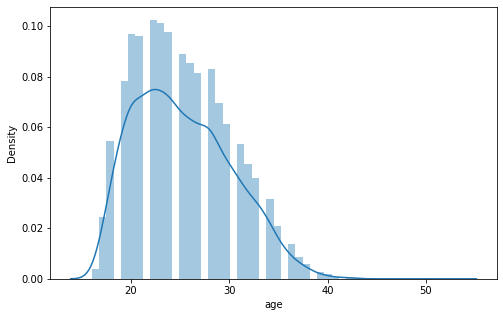

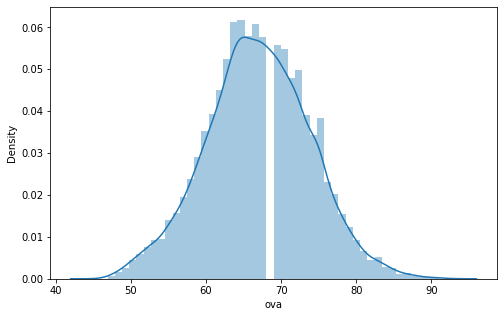

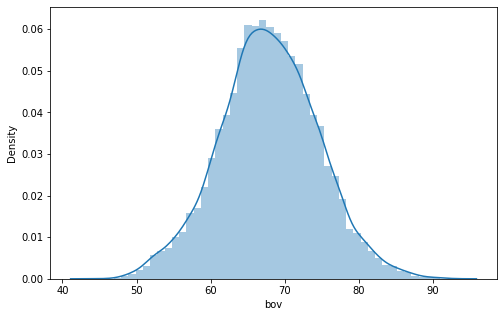

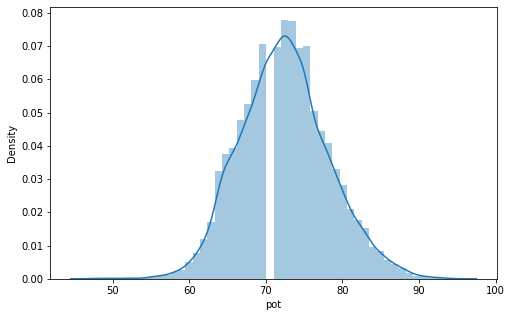

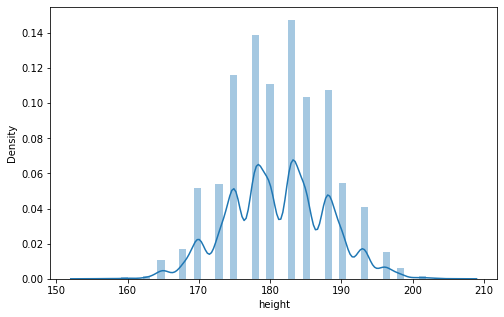

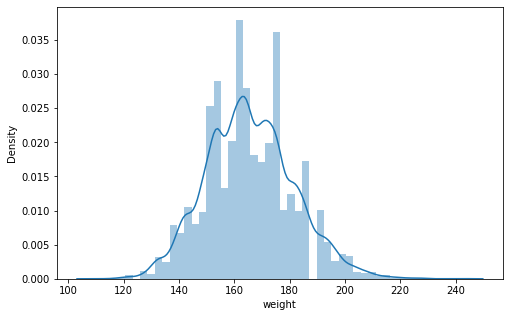

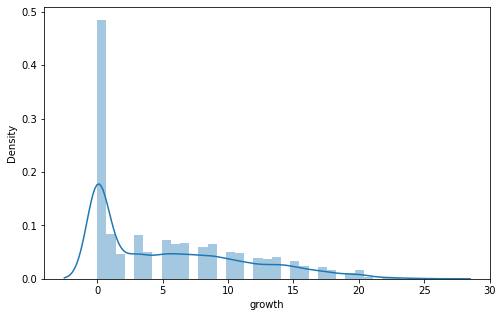

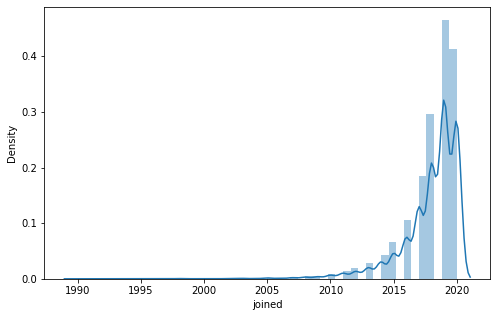

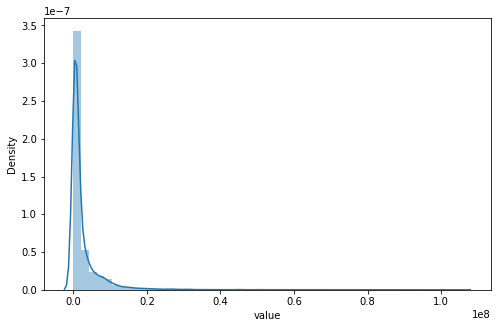

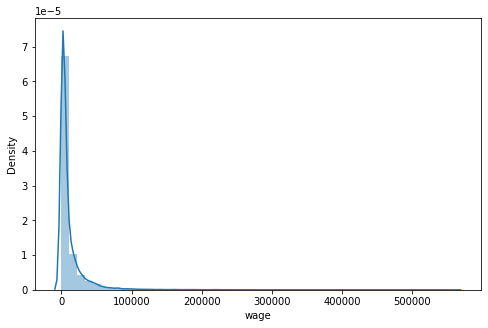

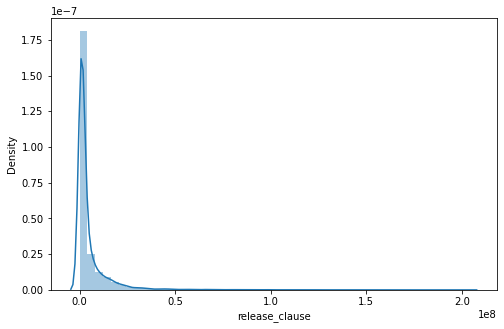

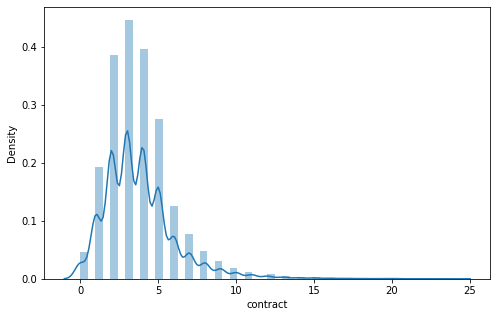

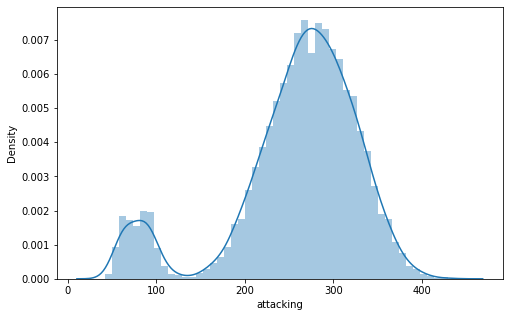

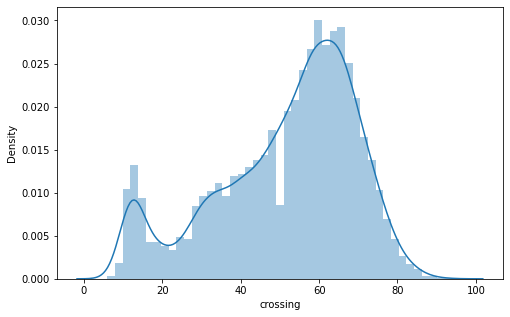

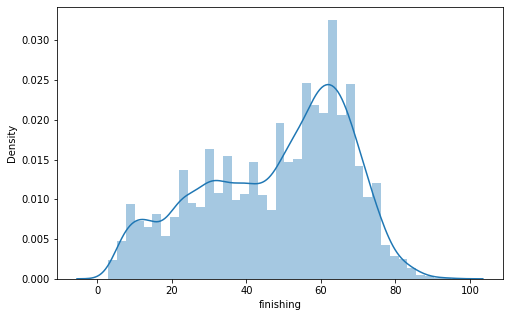

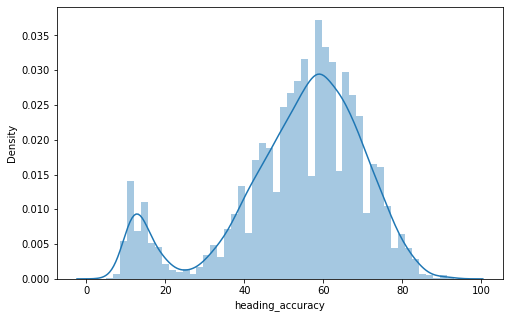

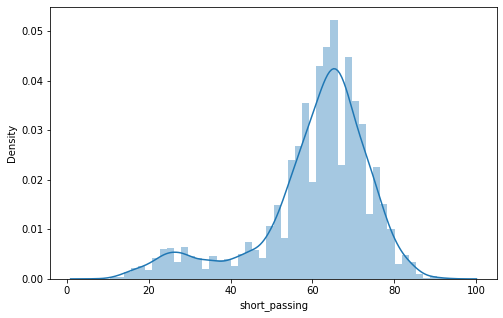

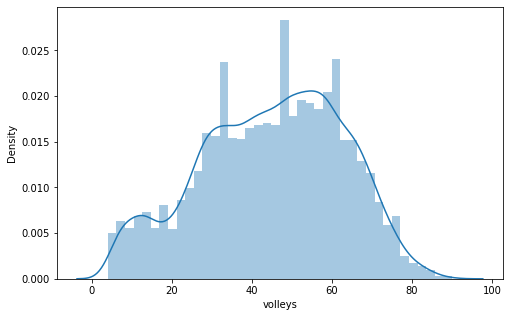

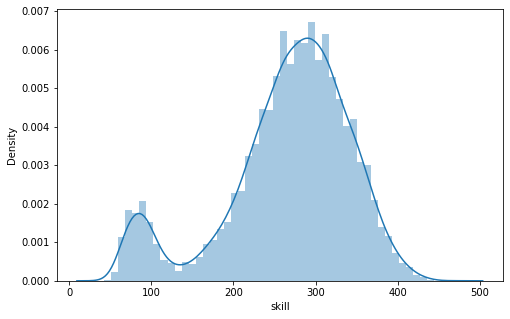

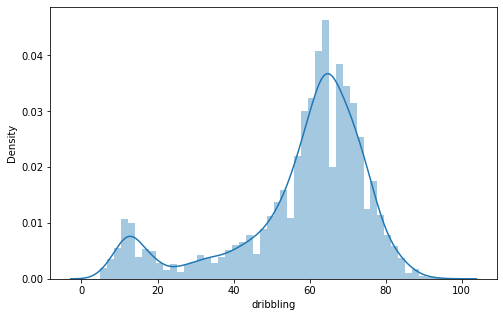

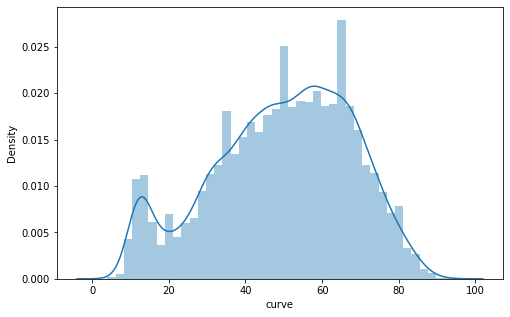

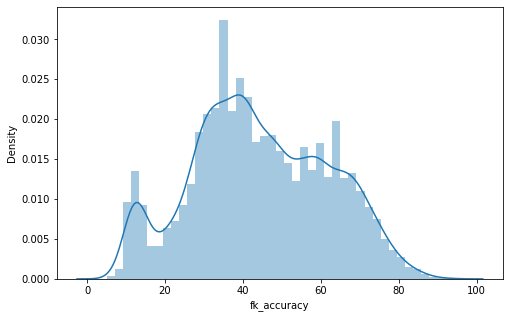

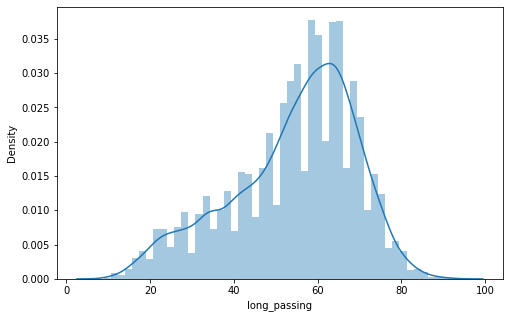

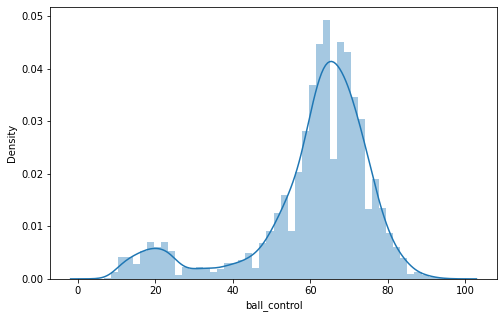

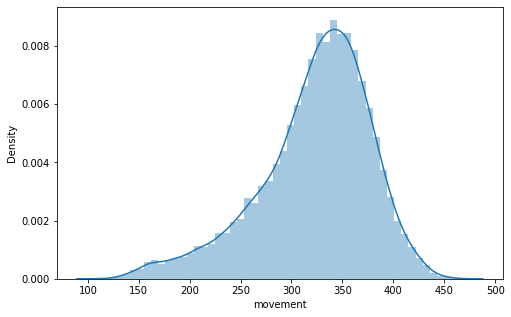

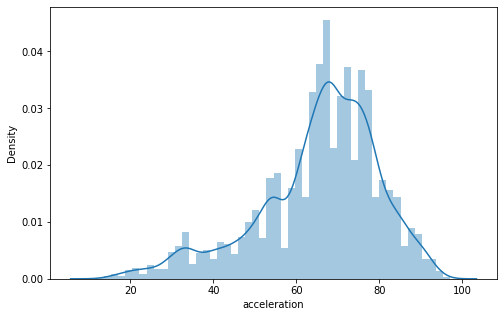

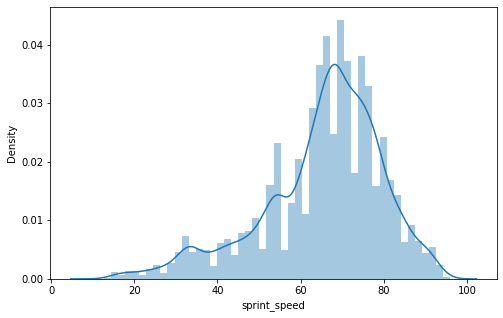

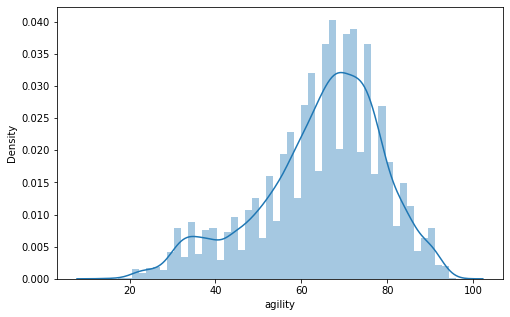

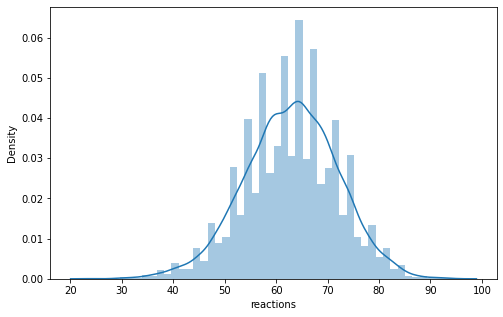

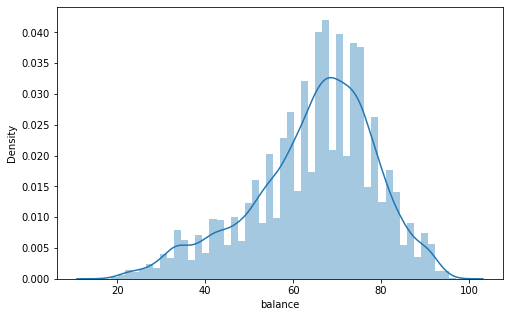

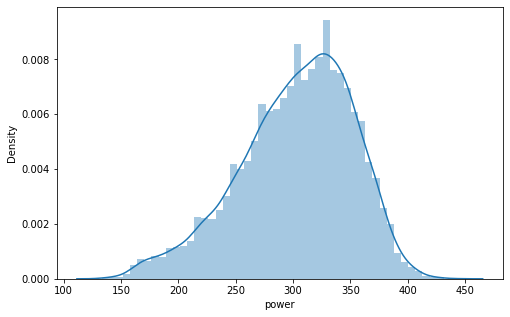

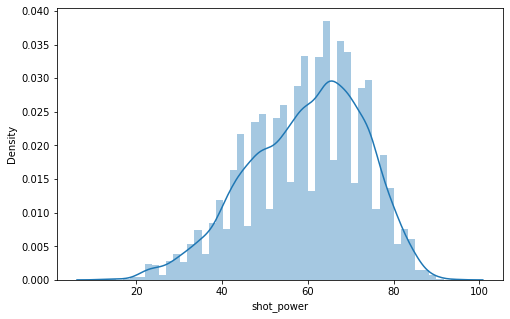

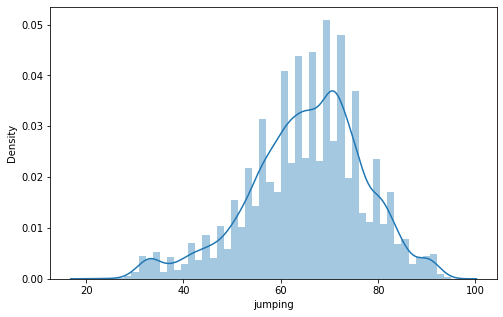

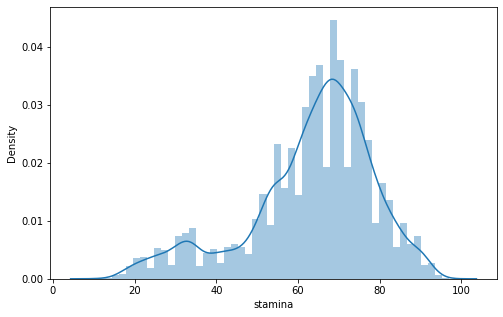

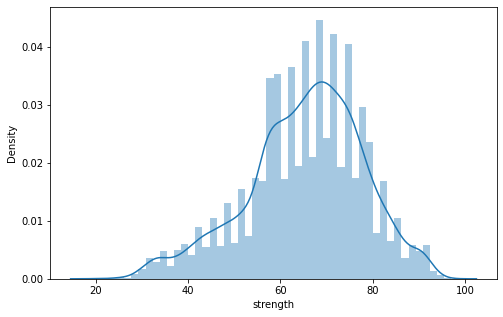

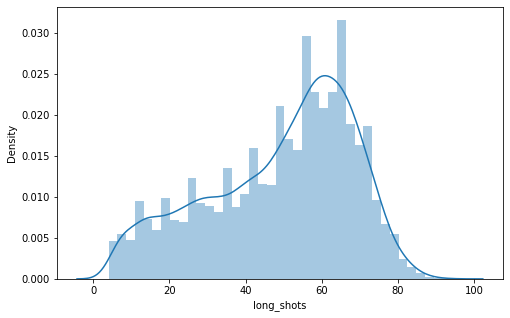

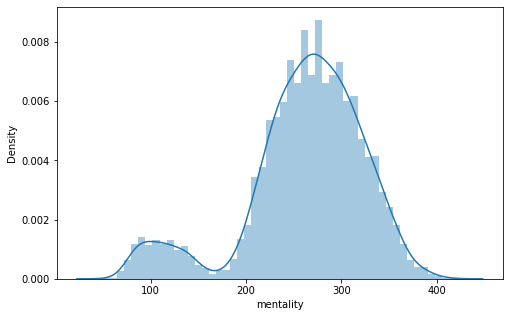

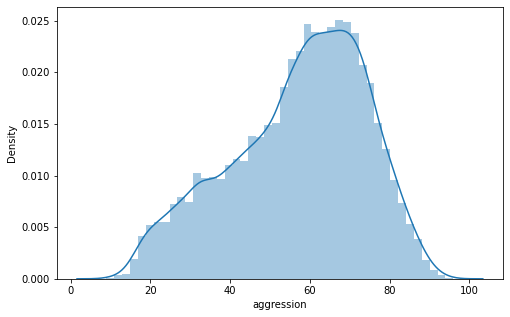

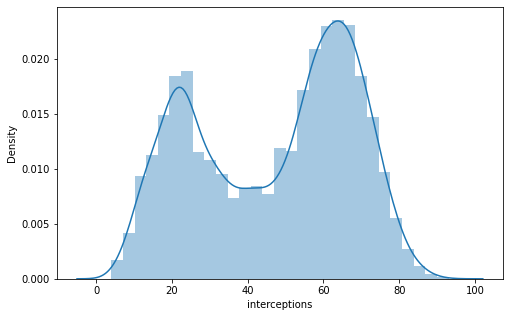

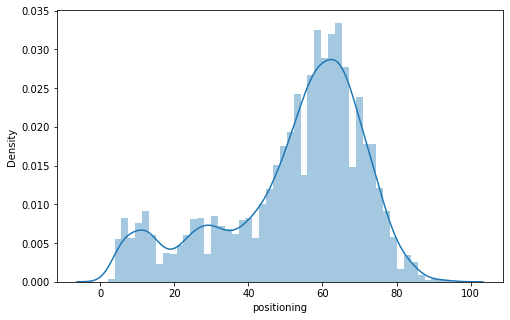

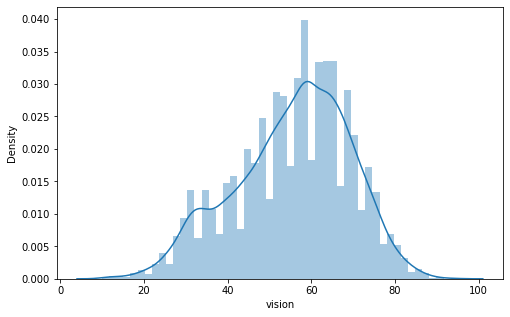

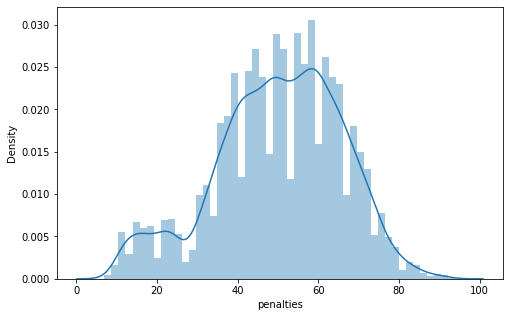

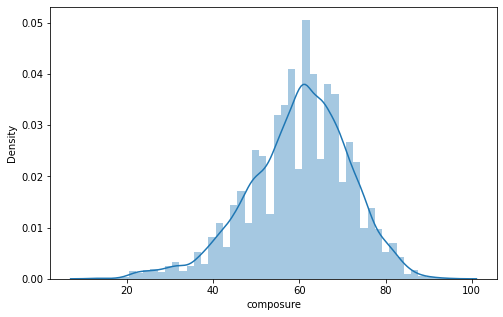

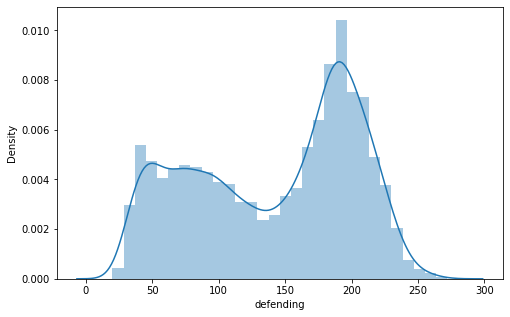

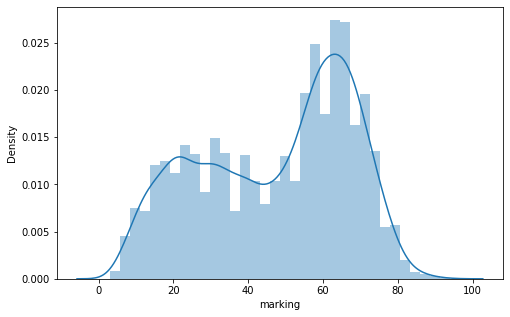

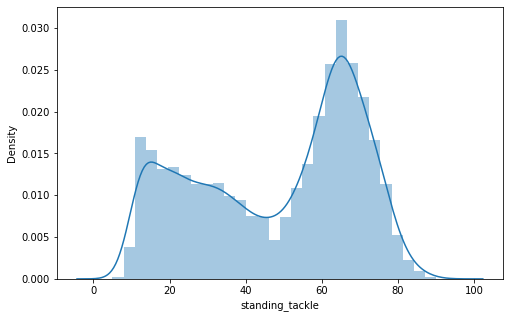

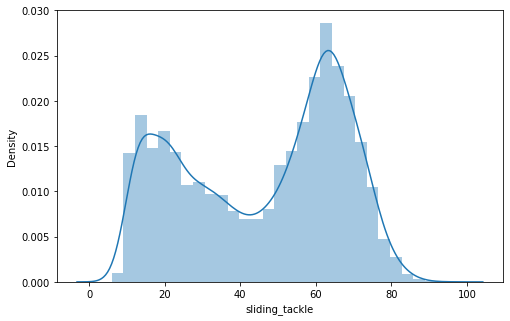

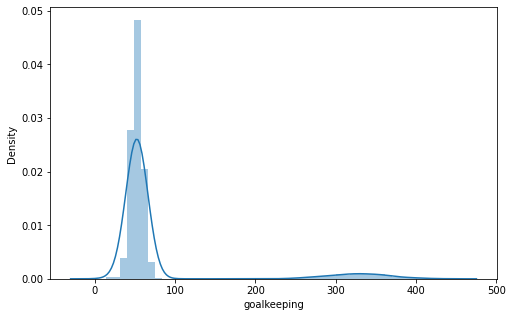

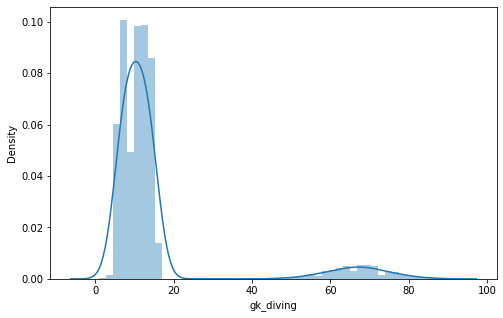

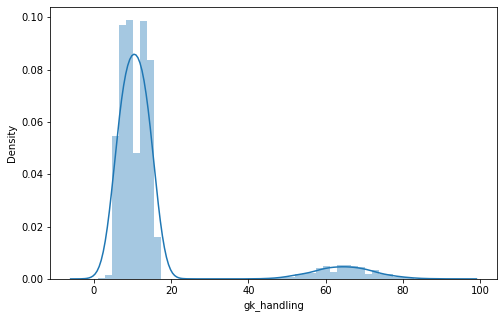

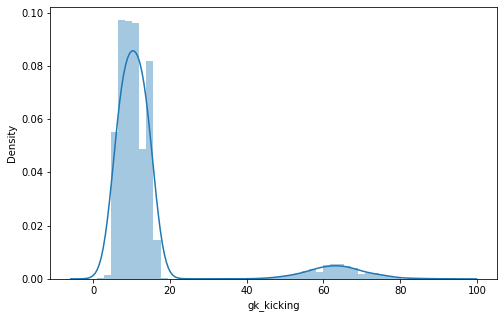

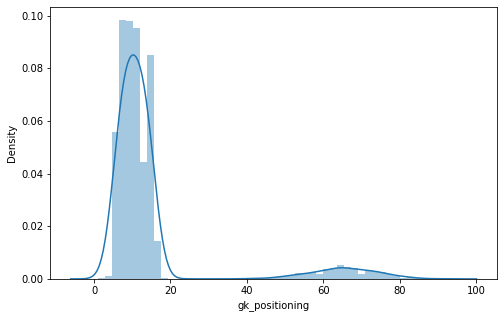

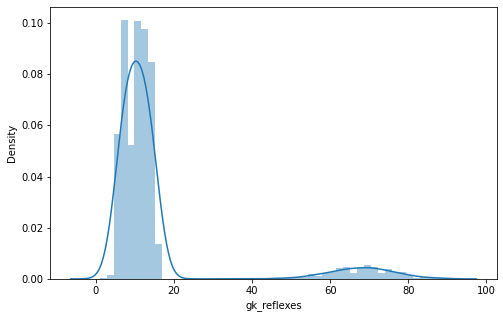

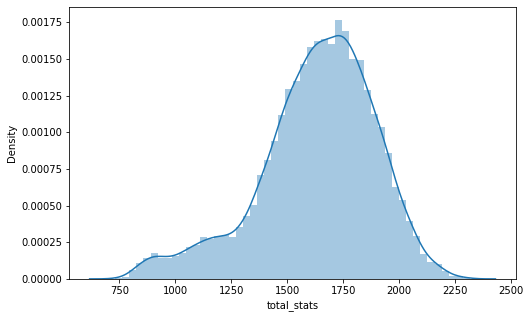

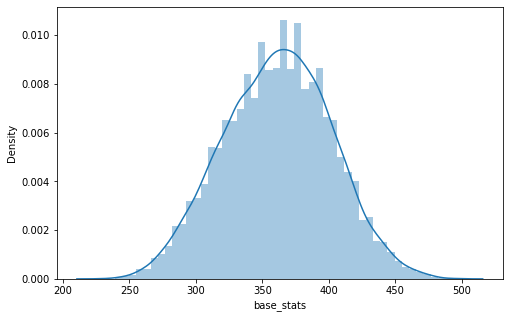

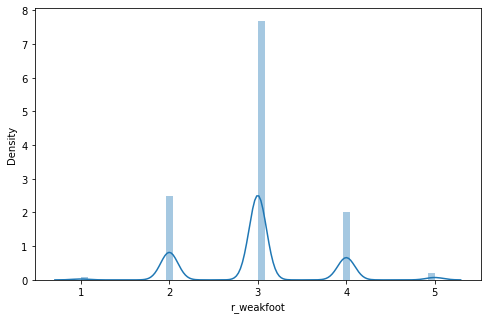

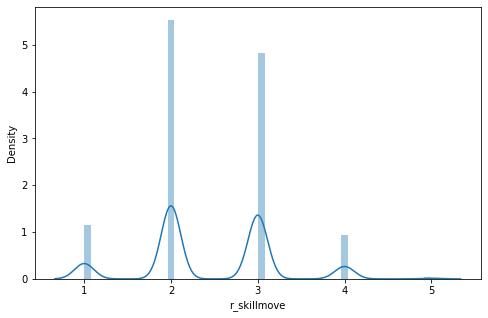

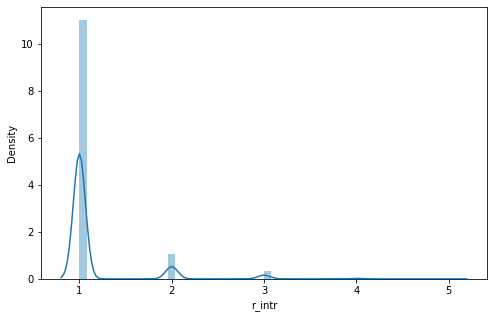

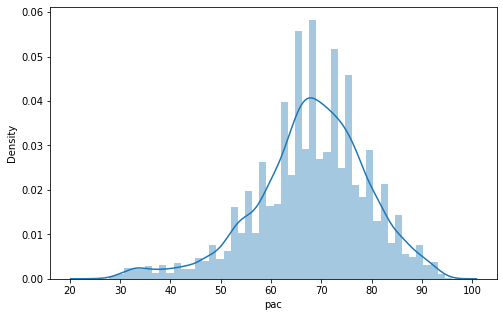

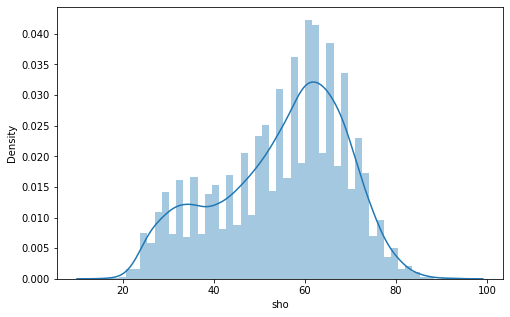

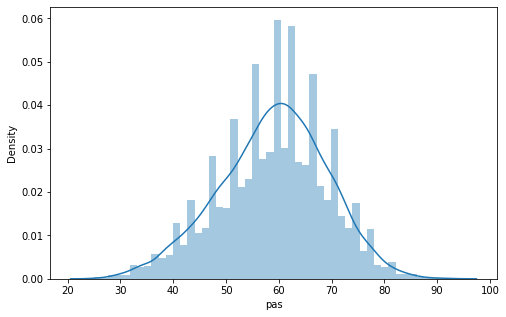

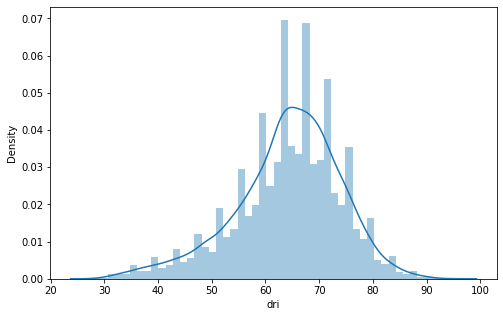

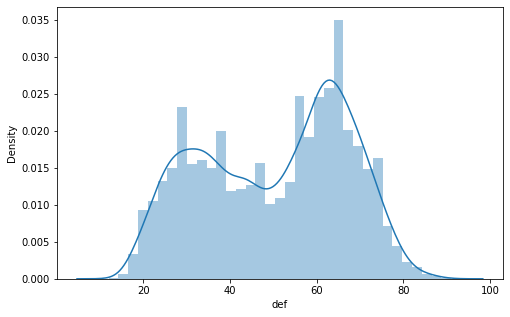

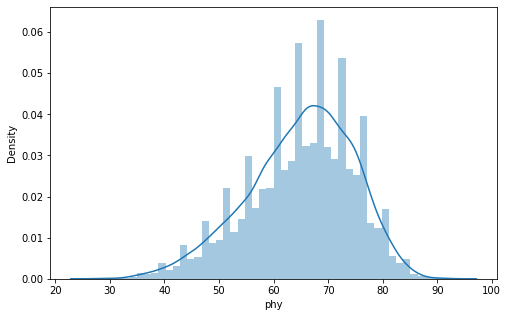

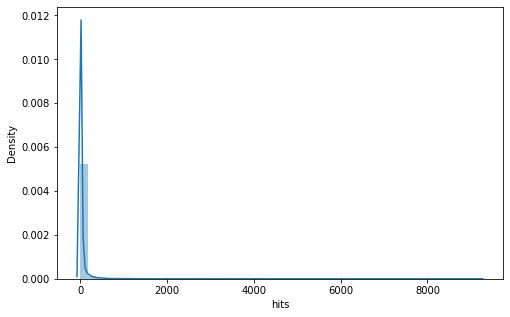

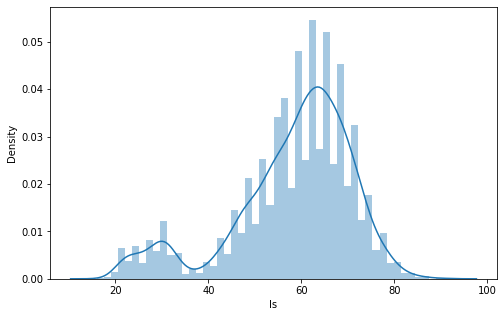

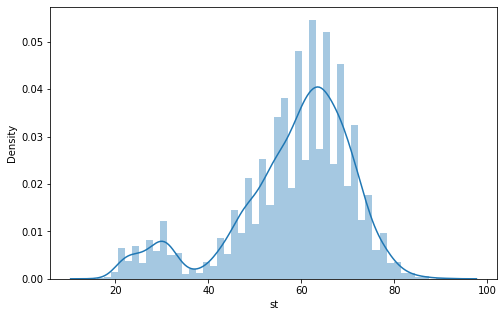

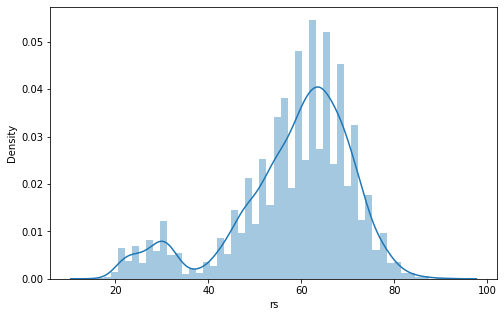

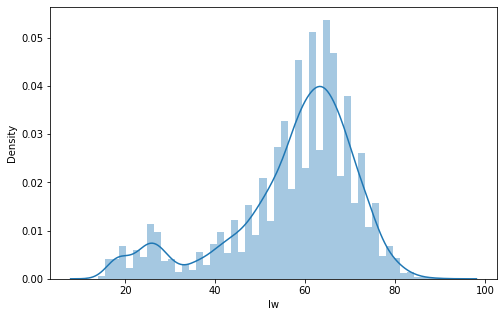

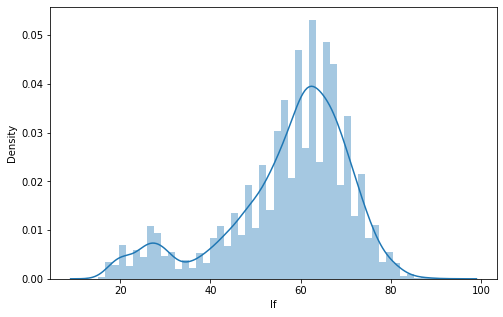

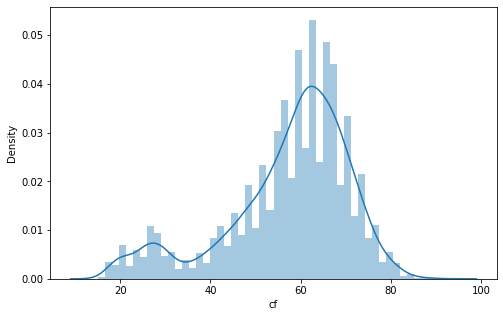

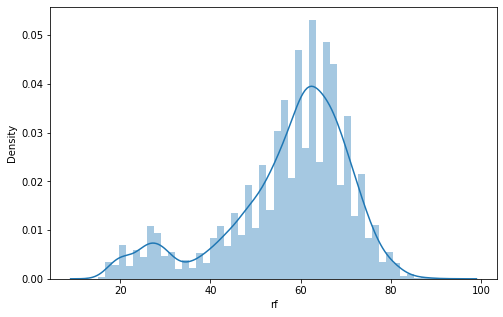

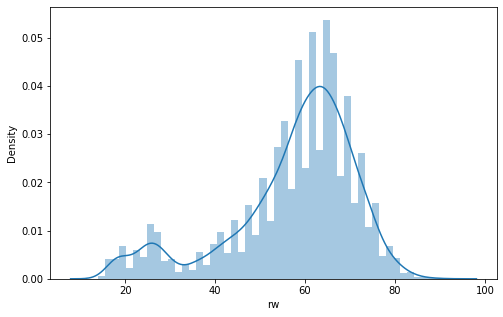

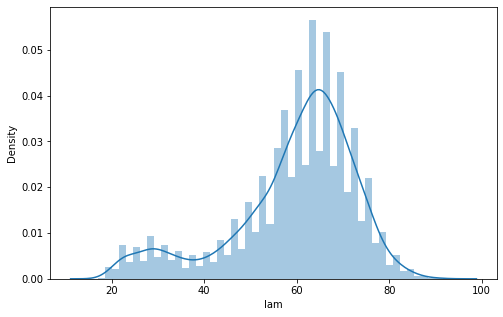

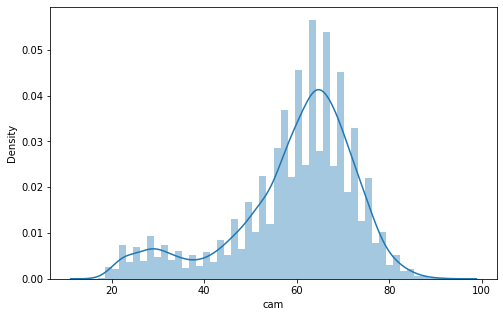

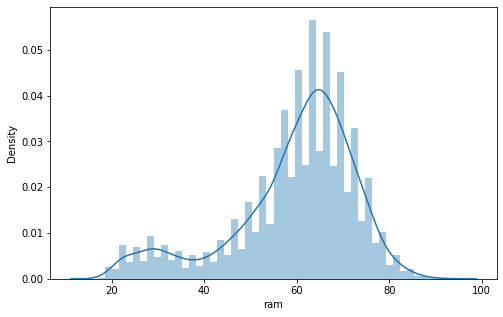

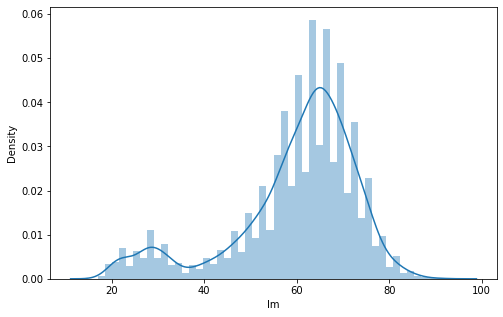

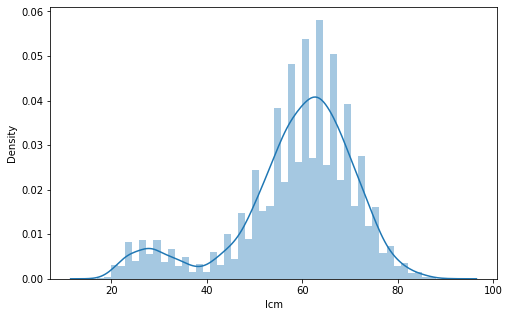

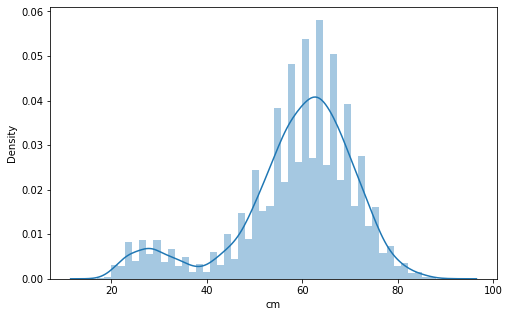

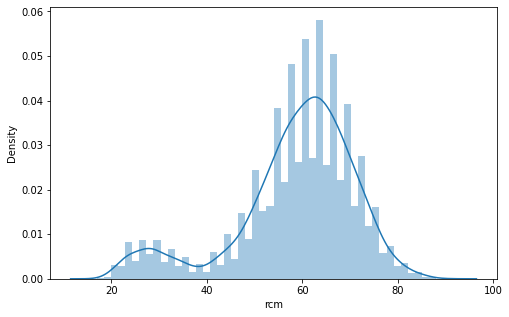

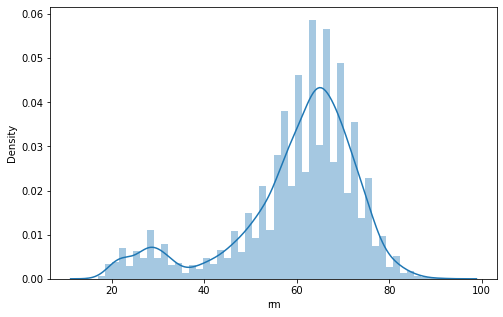

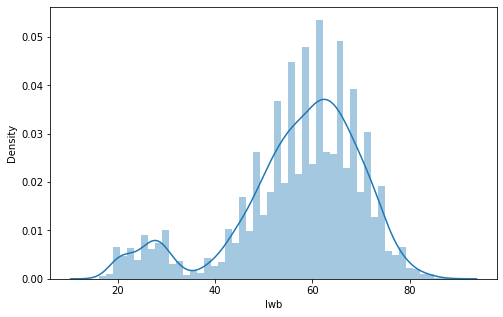

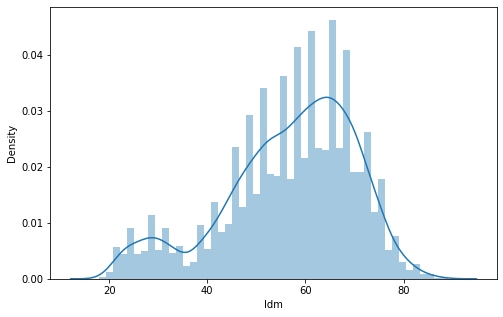

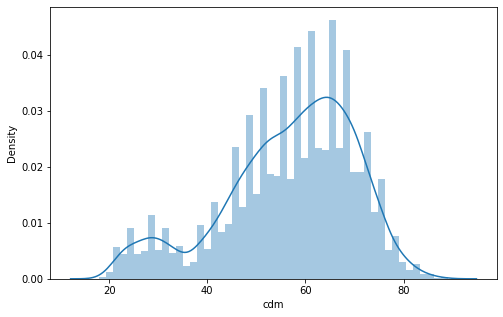

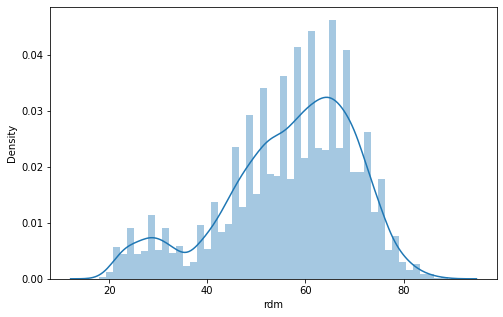

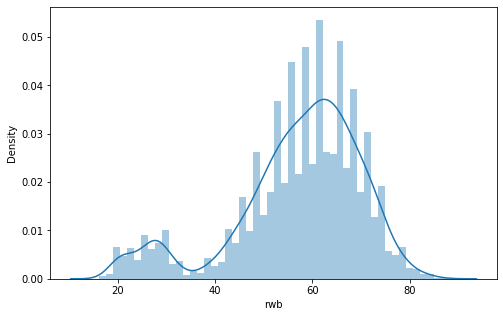

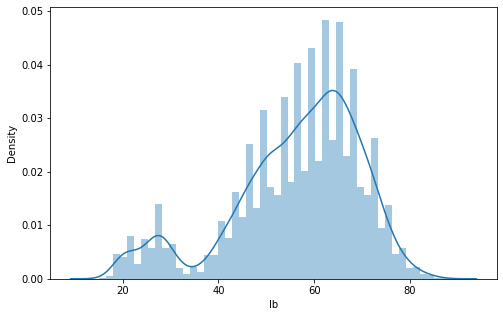

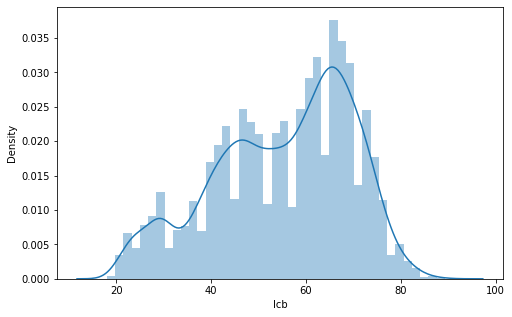

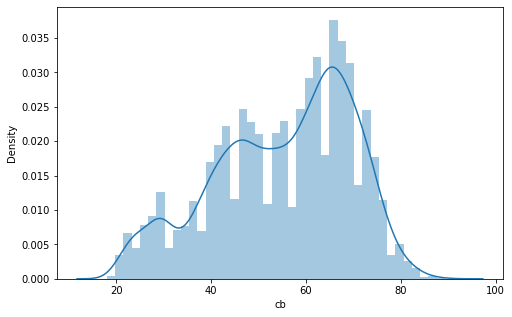

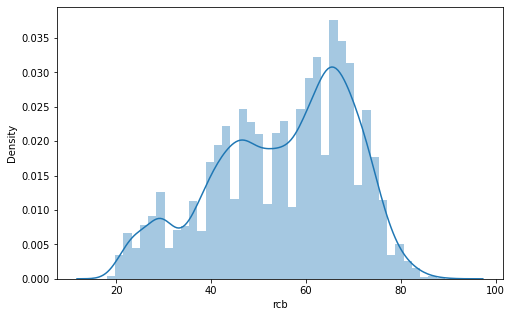

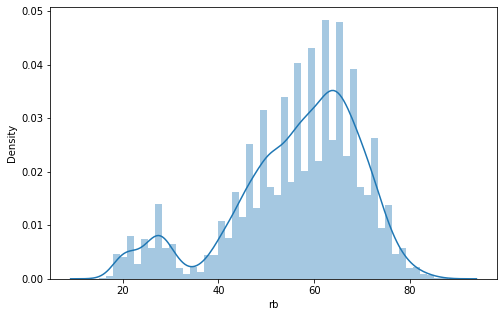

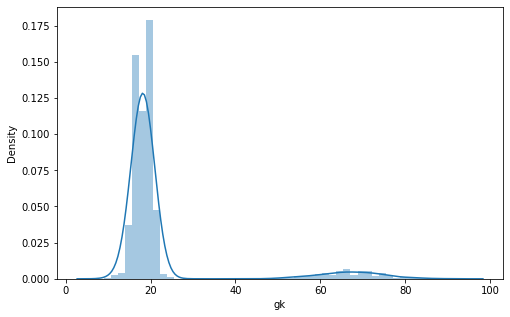

In [ ]:
import seaborn as sns
for column in data_num:
    plt.figure(figsize=(8,5))
    sns.distplot(data_num[column])
    plt.show()

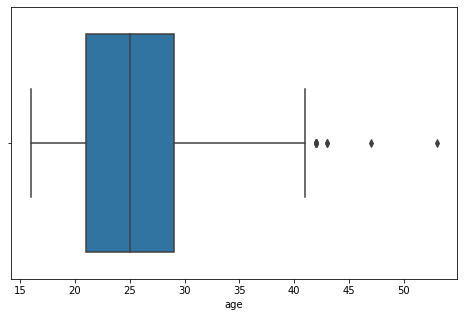

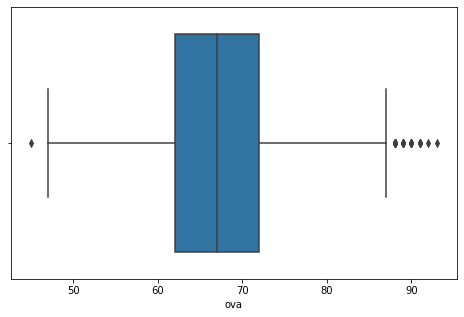

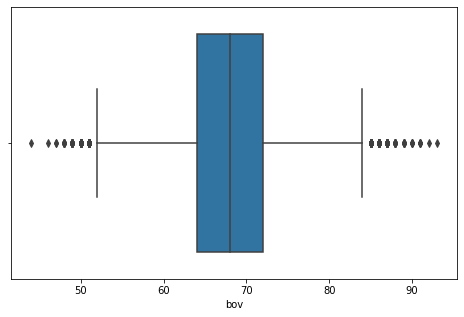

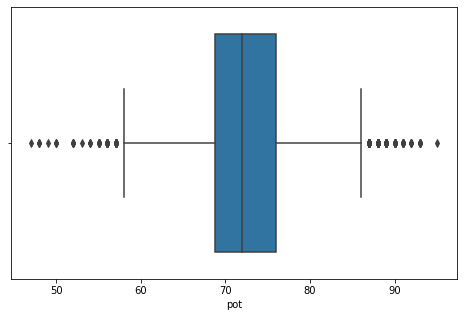

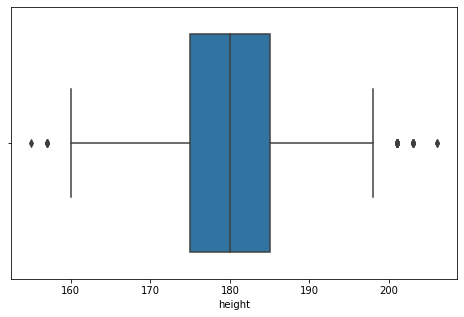

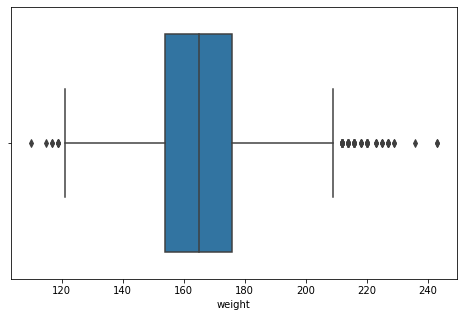

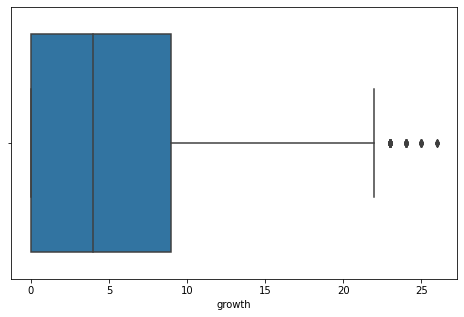

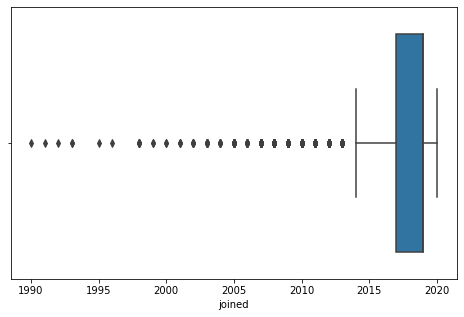

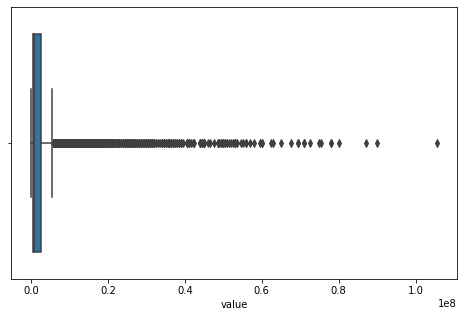

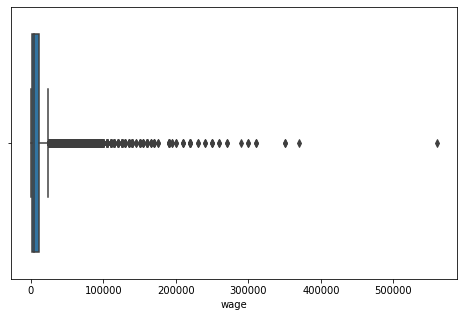

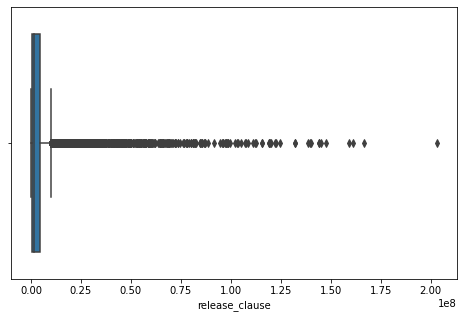

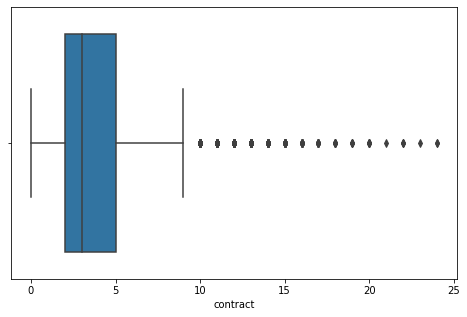

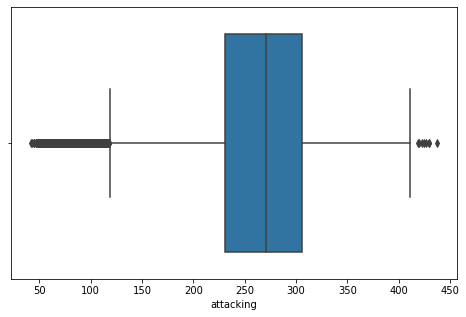

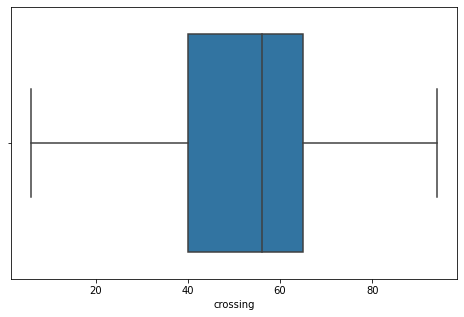

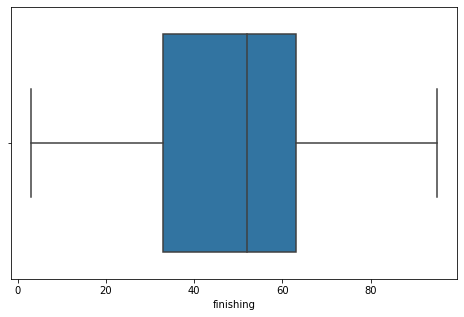

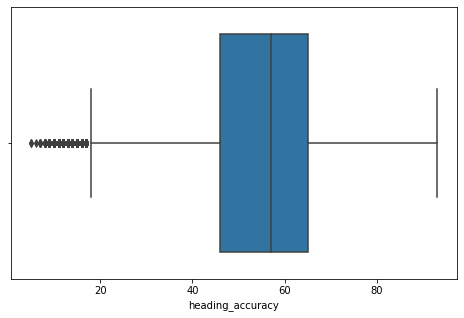

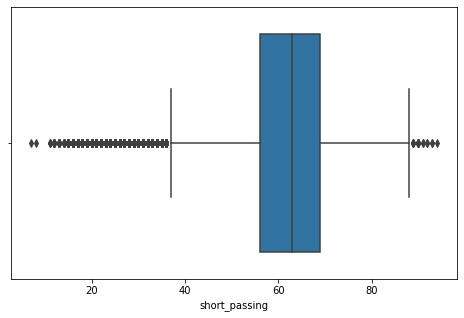

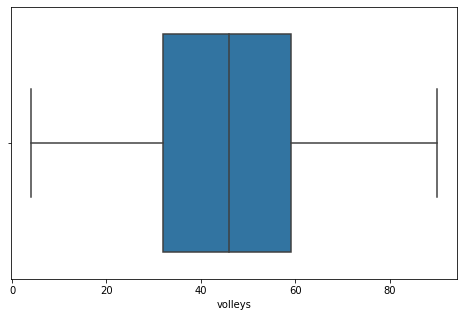

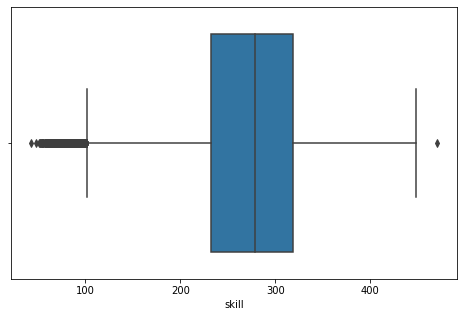

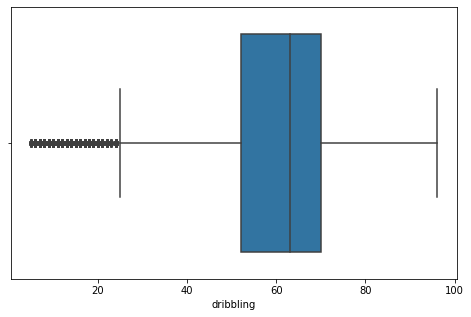

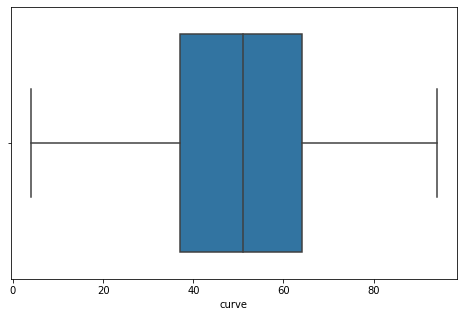

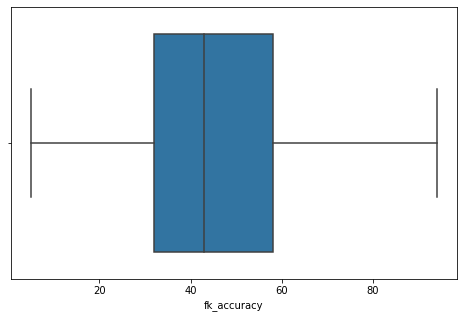

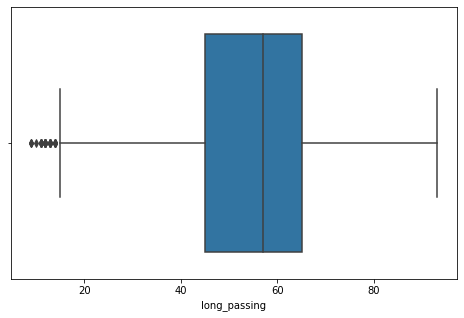

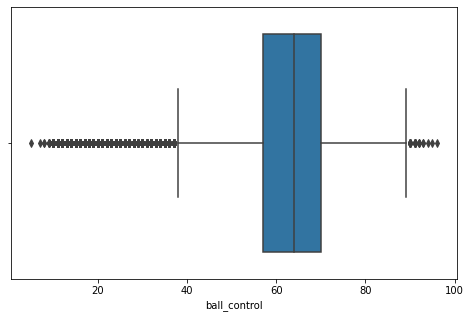

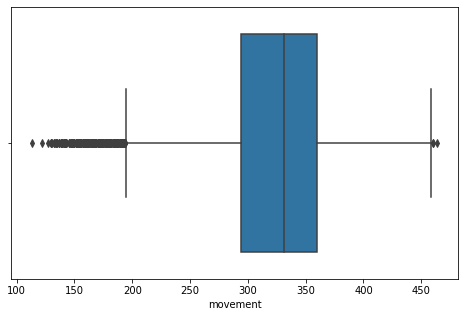

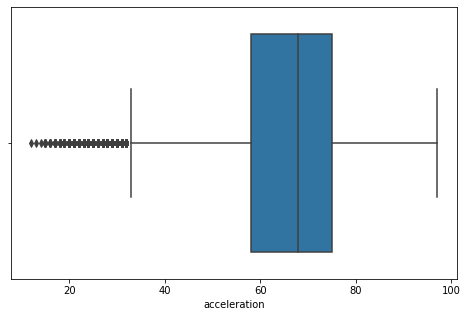

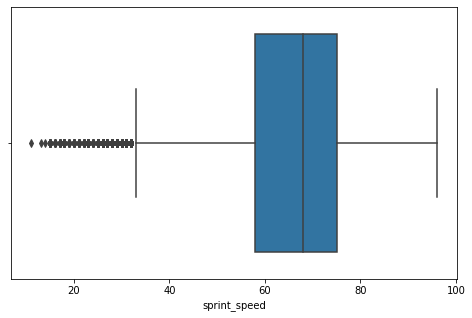

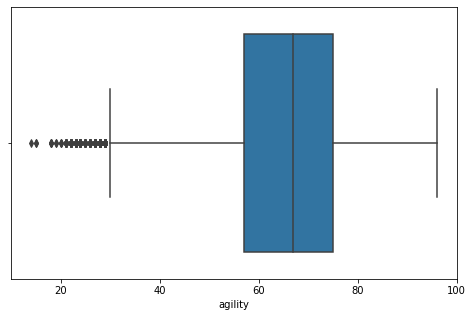

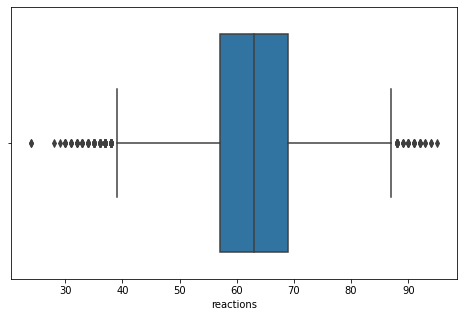

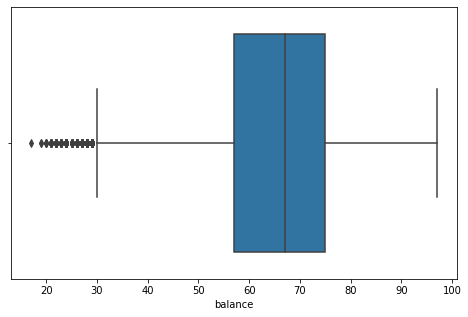

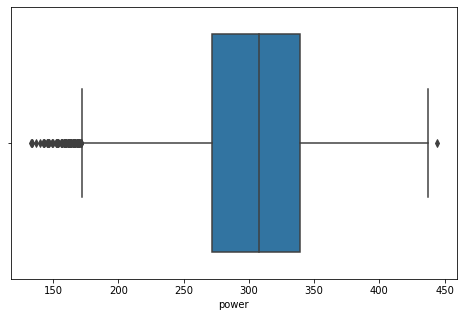

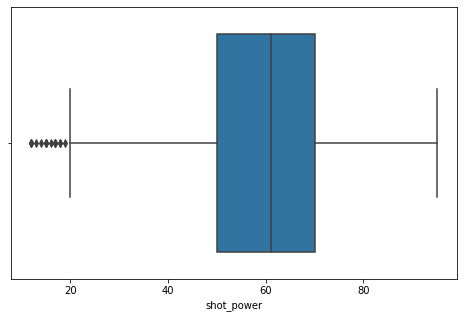

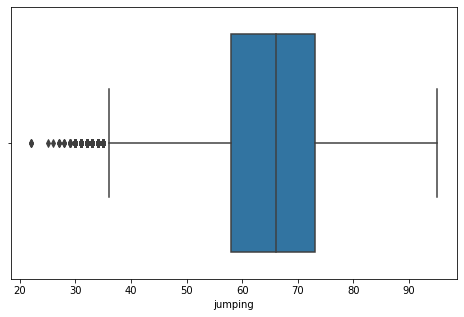

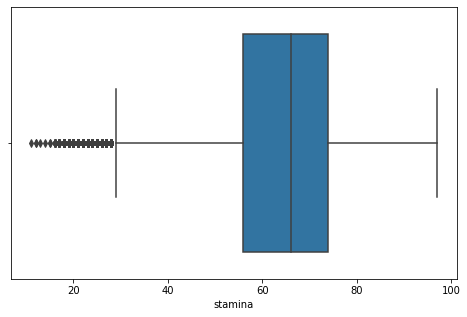

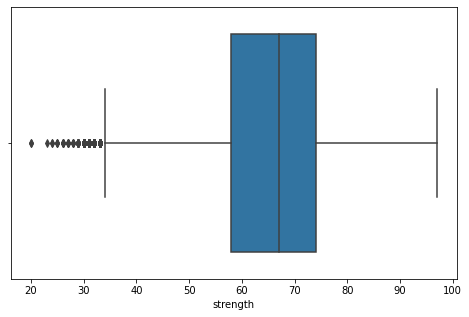

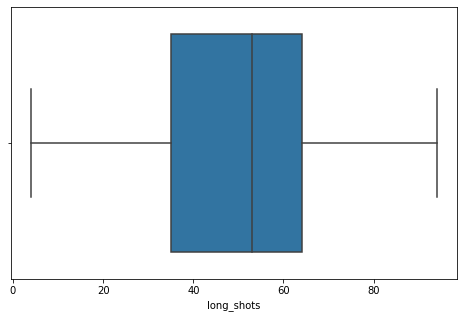

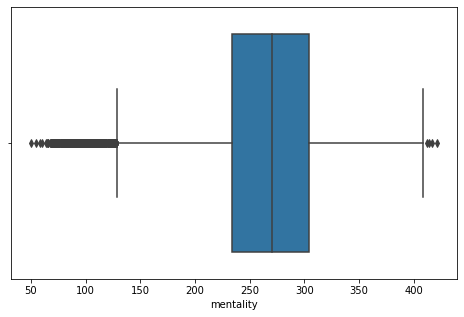

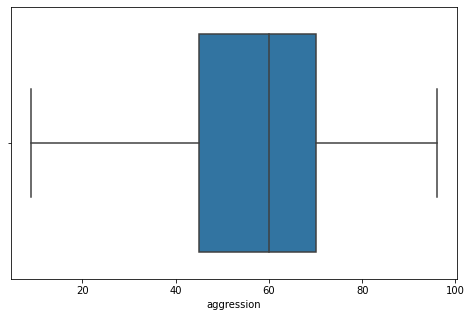

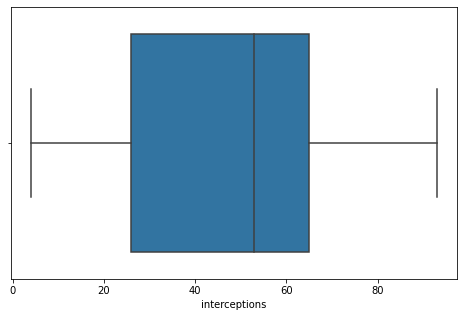

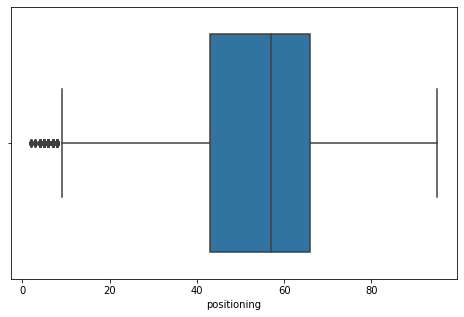

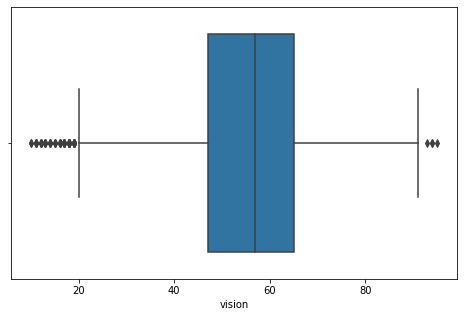

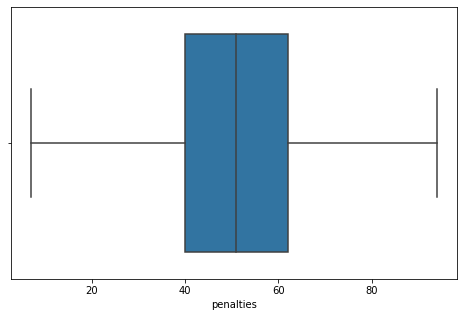

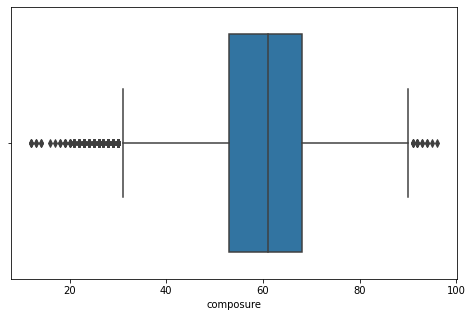

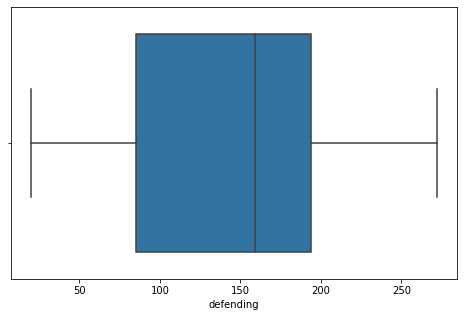

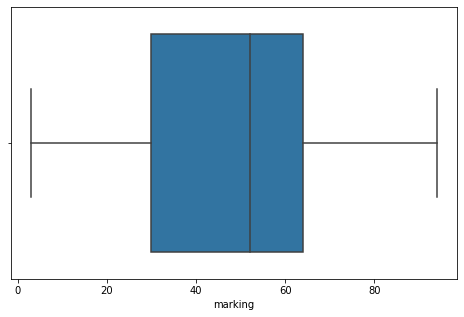

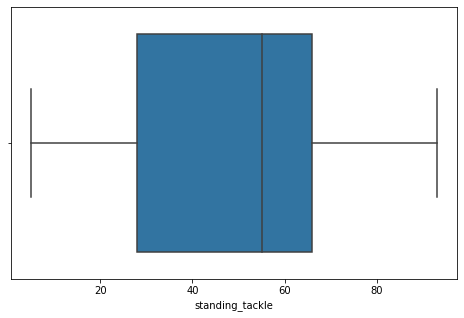

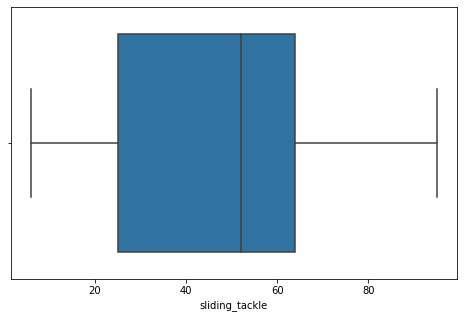

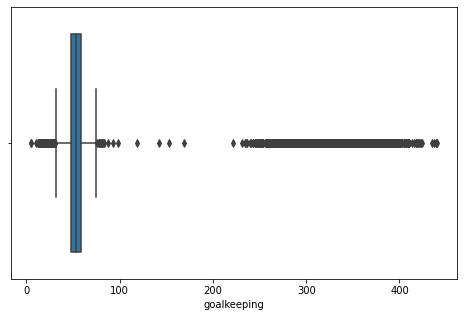

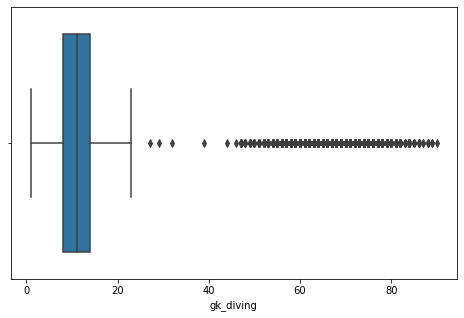

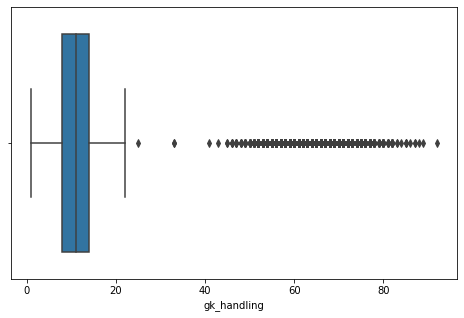

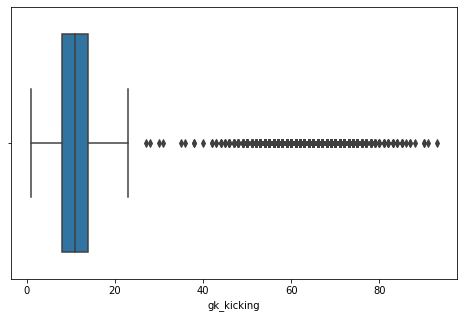

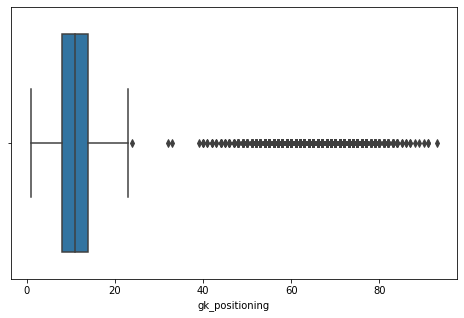

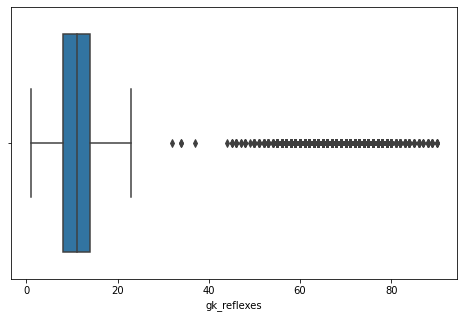

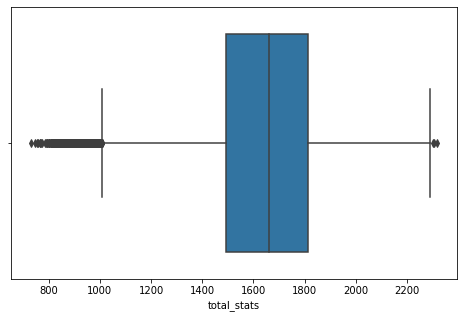

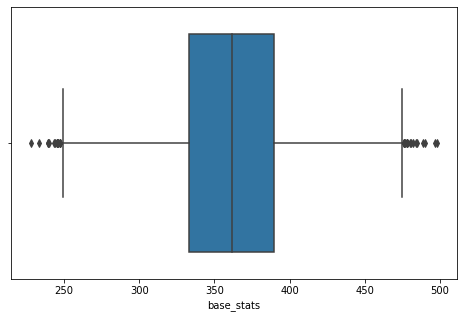

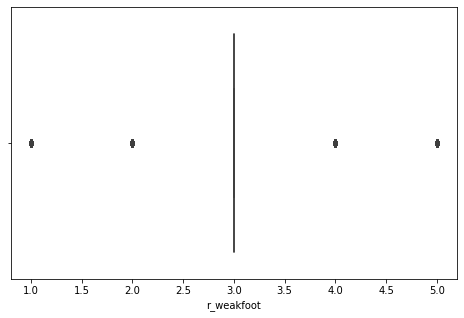

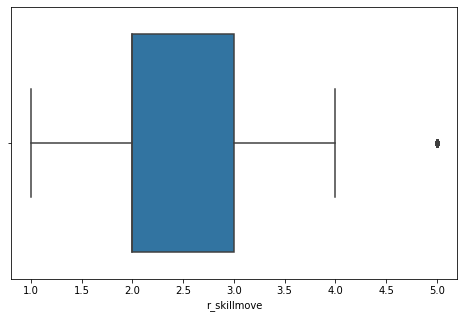

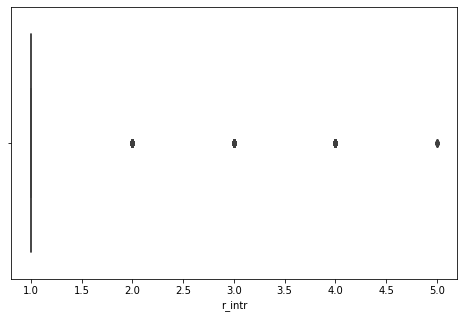

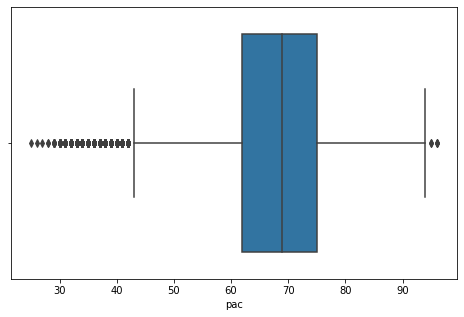

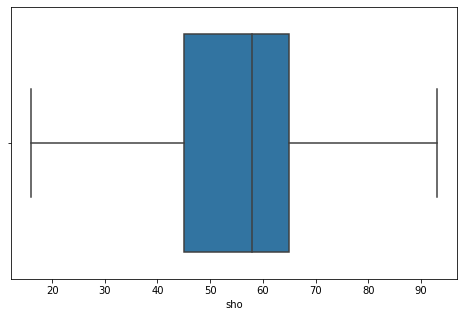

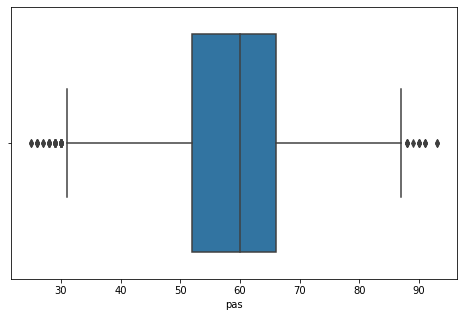

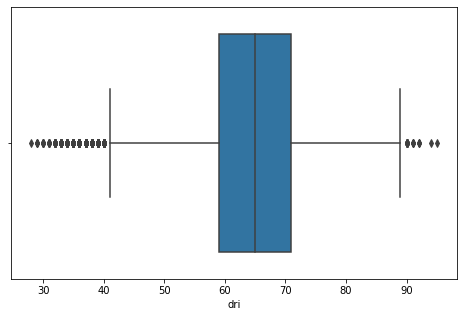

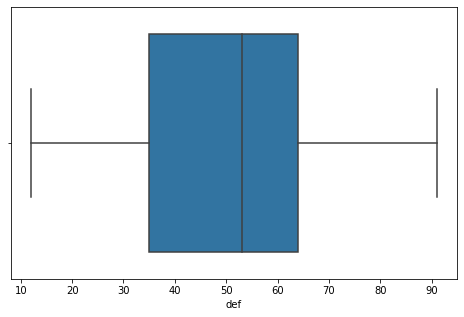

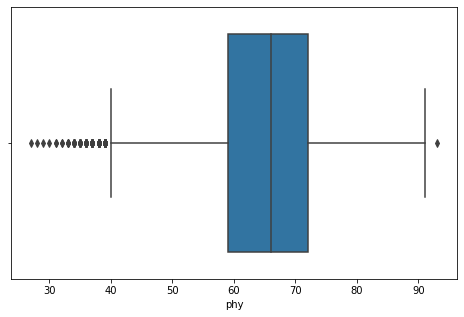

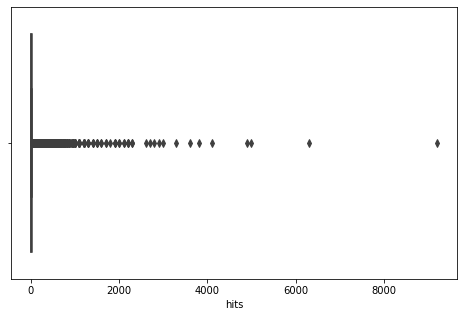

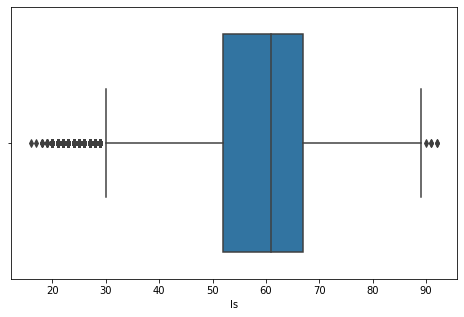

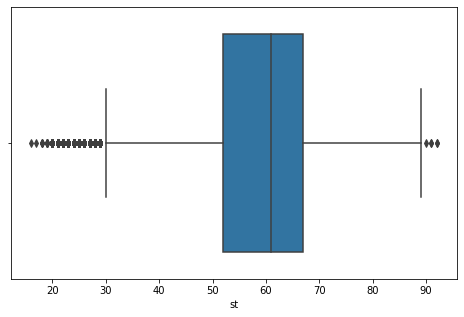

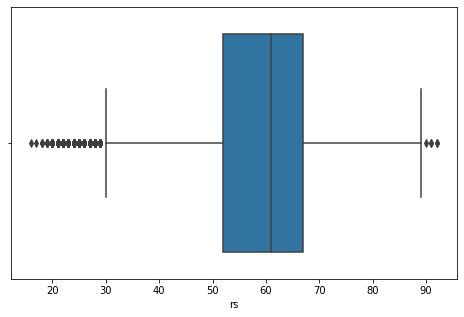

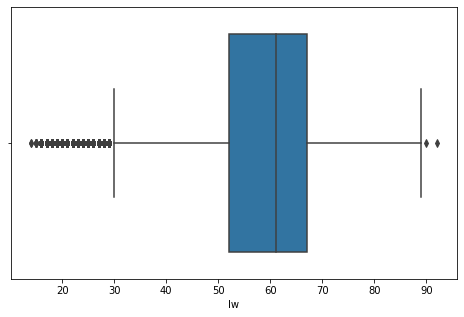

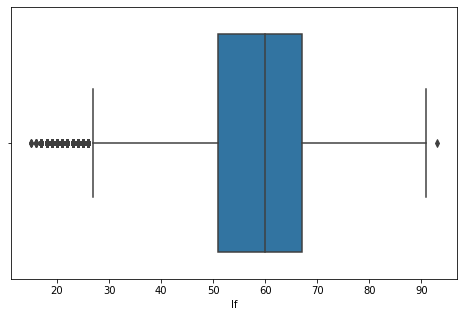

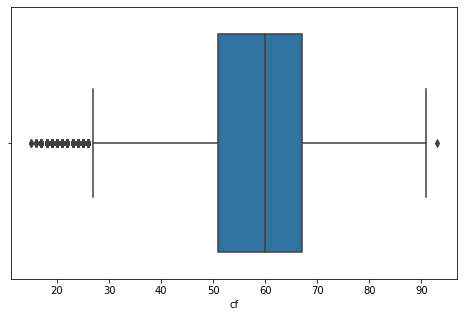

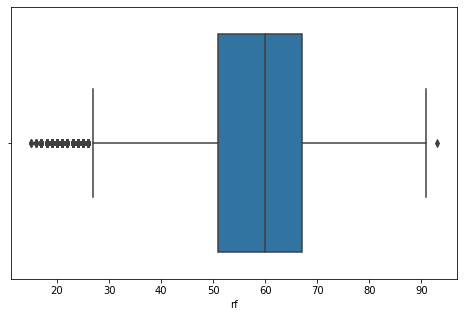

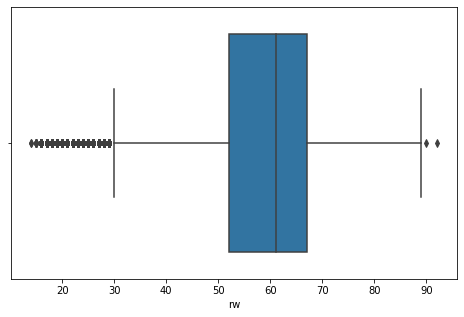

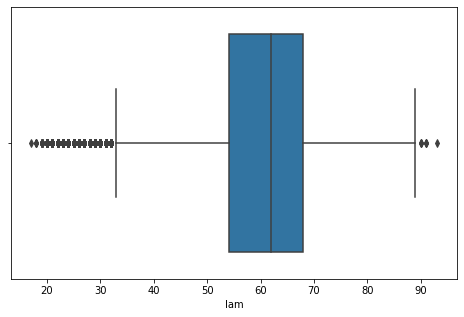

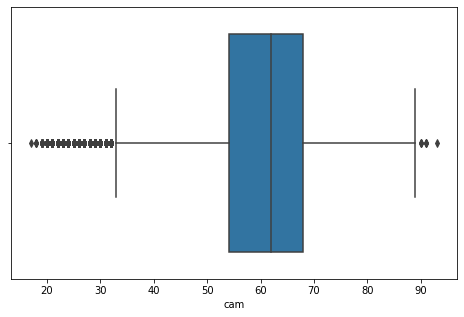

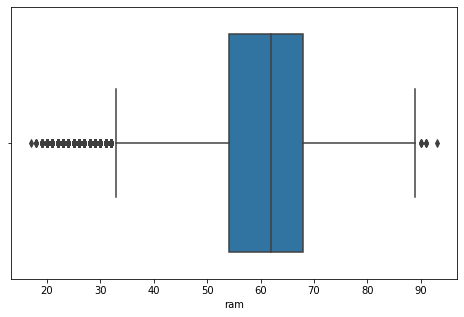

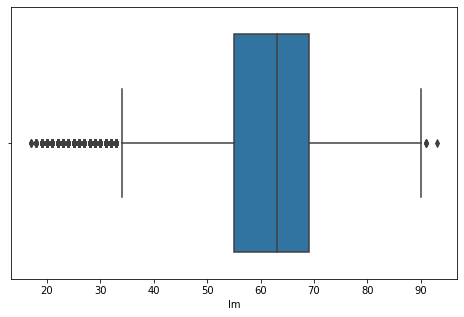

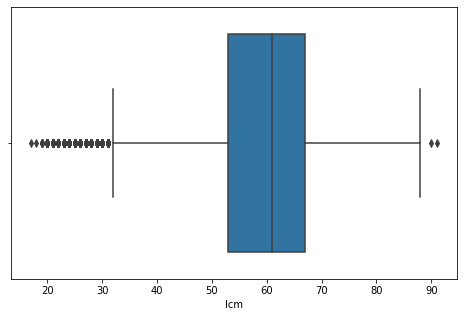

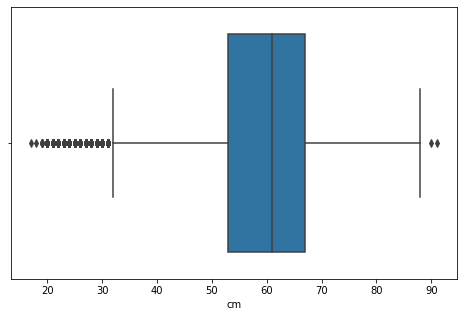

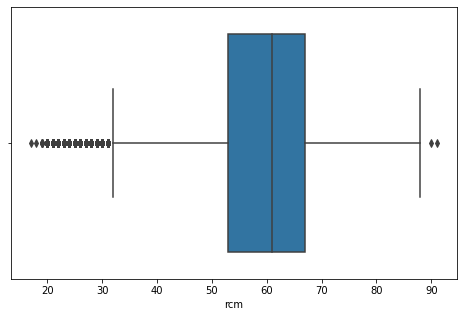

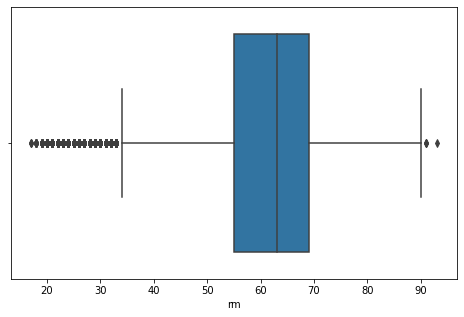

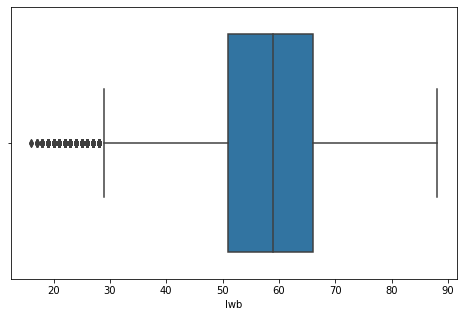

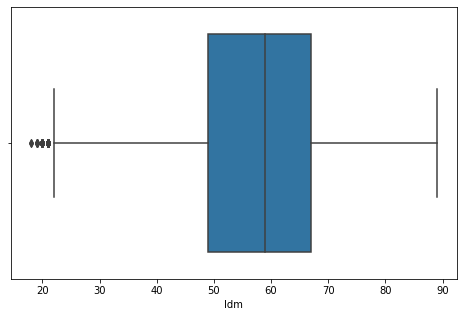

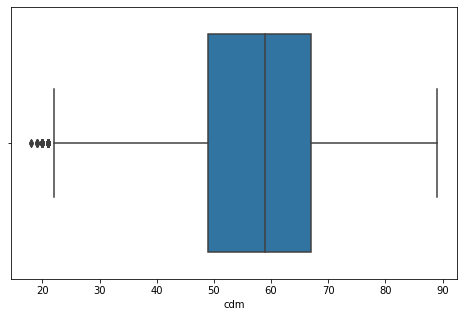

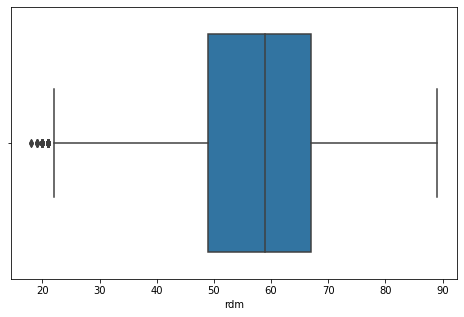

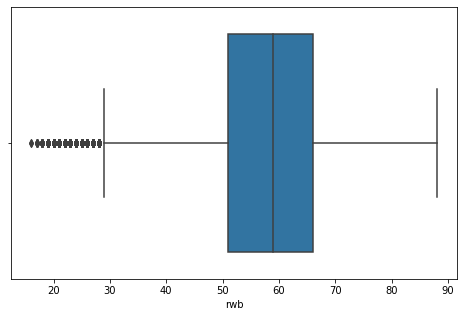

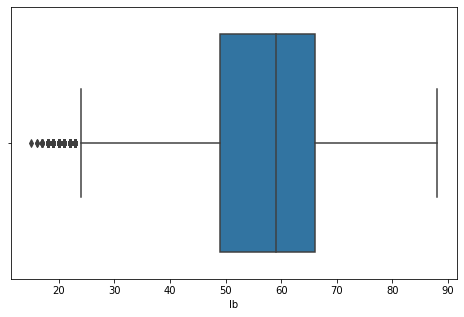

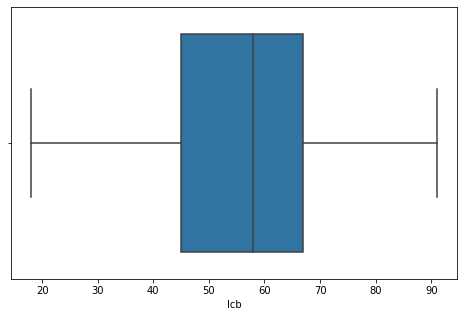

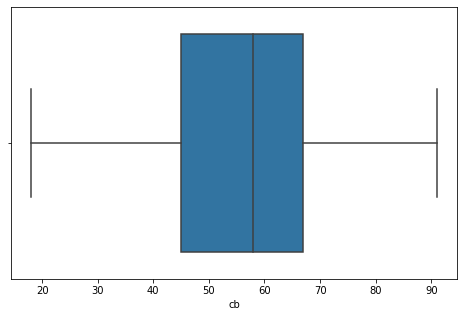

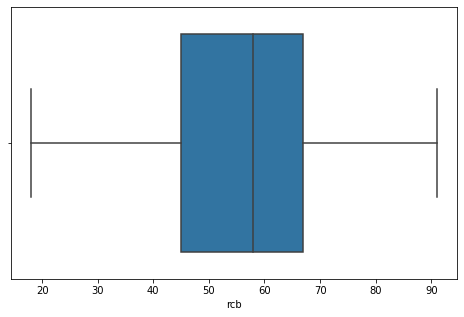

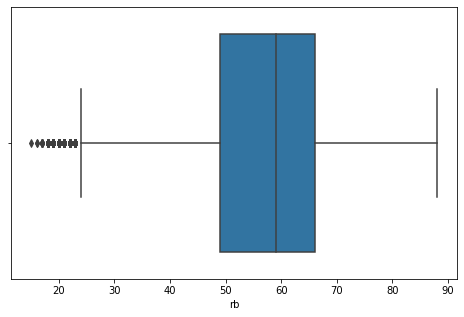

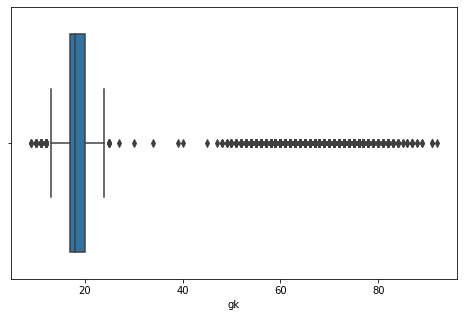

In [ ]:
for column in data_num:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=data_num[column])
    plt.show()

#### ! data improvements for better EDA !

#### | data splitting / grouping |

There is too much data for a sound overview of the correlations. Therefore I'm splitting data as follows:

1. Creating two separate datasets where one contains individual attributes and one umbrella attributes. 
    Umbrella attributes contain values that are aggregations or, weighted averages of individual attributes.
2. Adding columns for standard deviations of the values within umbrella attributes and accross attributes to check later on 
    if a homogeneity in skills plays a role in predicting performance/value



In [ ]:
# data_umb for umbrella attributes, data_att for individual attributes
data_umb = data_num.copy()
data_att = data_num.copy()

In [ ]:
def cc_stdev(df, columns, target_column):
    # function to store the stdev accross multiple columns for each row in a target column and delete original columns
    df[target_column] = ''
    
    for i in range(len(df)):
        df[target_column].iloc[i] = round(np.nanstd(df[columns].iloc[i]), 2)
    
    df[target_column] = df[target_column].apply(pd.to_numeric, downcast='float', errors='coerce')
    df = df.drop(columns=columns, axis=1)
    return df

def cc_mean(df, columns, target_column):
    # function to calculate mean accross multiple columns for each row, store in a target column and delete original
    df[target_column] = ''
    
    for i in range(len(df)):
        df[target_column].iloc[i] = round(np.nanmean(df[columns].iloc[i]), 2)
   
    df[target_column] = df[target_column].apply(pd.to_numeric, downcast='float', errors='coerce')
    df = df.drop(columns=columns, axis=1)
    return df

In [ ]:
# replacing attribute columns with stdev or average columns

att_pac = ['acceleration', 'sprint_speed']
att_sho = ['finishing', 'long_shots', 'shot_power', 'penalties', 'volleys', 'positioning']
att_pas = ['crossing', 'curve', 'fk_accuracy', 'long_passing', 'short_passing', 'vision']
att_dri = ['agility', 'balance', 'ball_control', 'composure', 'dribbling', 'reactions']
att_def = ['heading_accuracy', 'interceptions', 'sliding_tackle', 'standing_tackle', 'marking']
att_phy = ['aggression', 'jumping', 'stamina', 'strength']
att_gk = ['gk_handling', 'gk_kicking', 'gk_diving', 'gk_positioning', 'gk_reflexes']
pos = ['ls', 'st', 'rs','lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
pos_s = ['ls', 'st', 'rs']
pos_m = ['lw', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'ldm', 'cdm', 'rdm']
pos_b = ['lf', 'cf', 'rf', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'lwb']

data_umb = cc_stdev(data_umb, columns=att_pac, target_column='pac_stdev')
data_umb = cc_stdev(data_umb, columns=att_sho, target_column='sho_stdev')
data_umb = cc_stdev(data_umb, columns=att_pas, target_column='pas_stdev')
data_umb = cc_stdev(data_umb, columns=att_dri, target_column='dri_stdev')
data_umb = cc_stdev(data_umb, columns=att_def, target_column='def_stdev')
data_umb = cc_stdev(data_umb, columns=att_phy, target_column='phy_stdev')
data_umb = cc_stdev(data_umb, columns=att_gk, target_column='gk_stdev')
data_umb = cc_mean(data_umb, columns=pos, target_column='pos_avg')

data_att = cc_mean(data_att, columns=pos_s, target_column='s_avg')
data_att = cc_mean(data_att, columns=pos_m, target_column='m_avg')
data_att = cc_mean(data_att, columns=pos_b, target_column='b_avg')


In [ ]:
# dropping columns with umbrella attributes
drop_umb = ['attacking', 'skill', 'movement', 'power', 'mentality', 'pac', 'sho', 'pas', 'dri', 'def', 'phy', 'total_stats', 'base_stats']

data_att = data_att.drop(columns=drop_umb, axis=1)


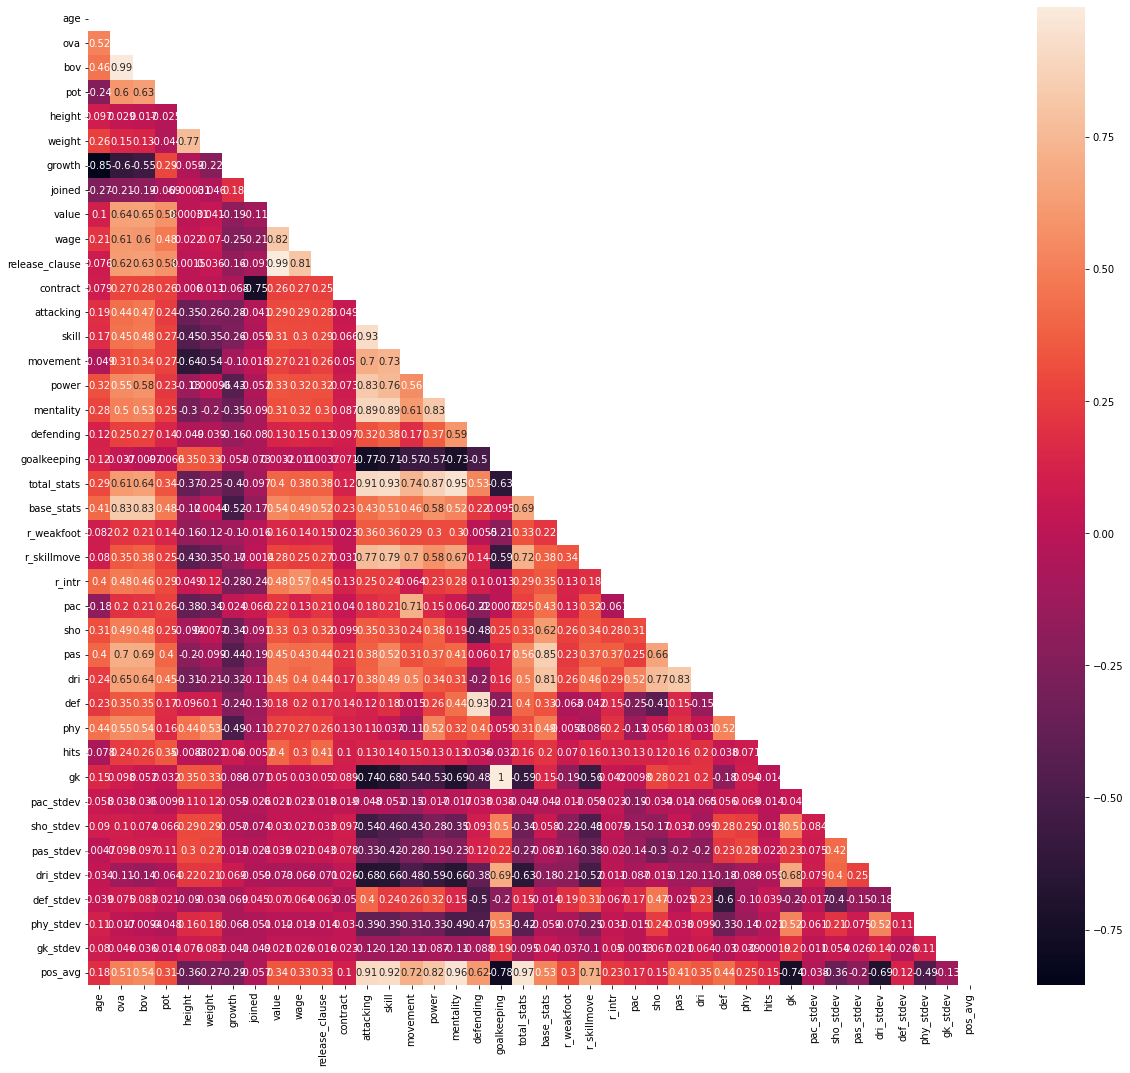

In [ ]:
# heatmap for data including umbrella attributes

mask = np.zeros_like(data_umb.corr())

mask[np.triu_indices_from(mask)] = True 

fig, ax = plt.subplots(figsize=(20, 18))
ax = sns.heatmap(data_umb.corr(), mask=mask, annot=True)
plt.show()

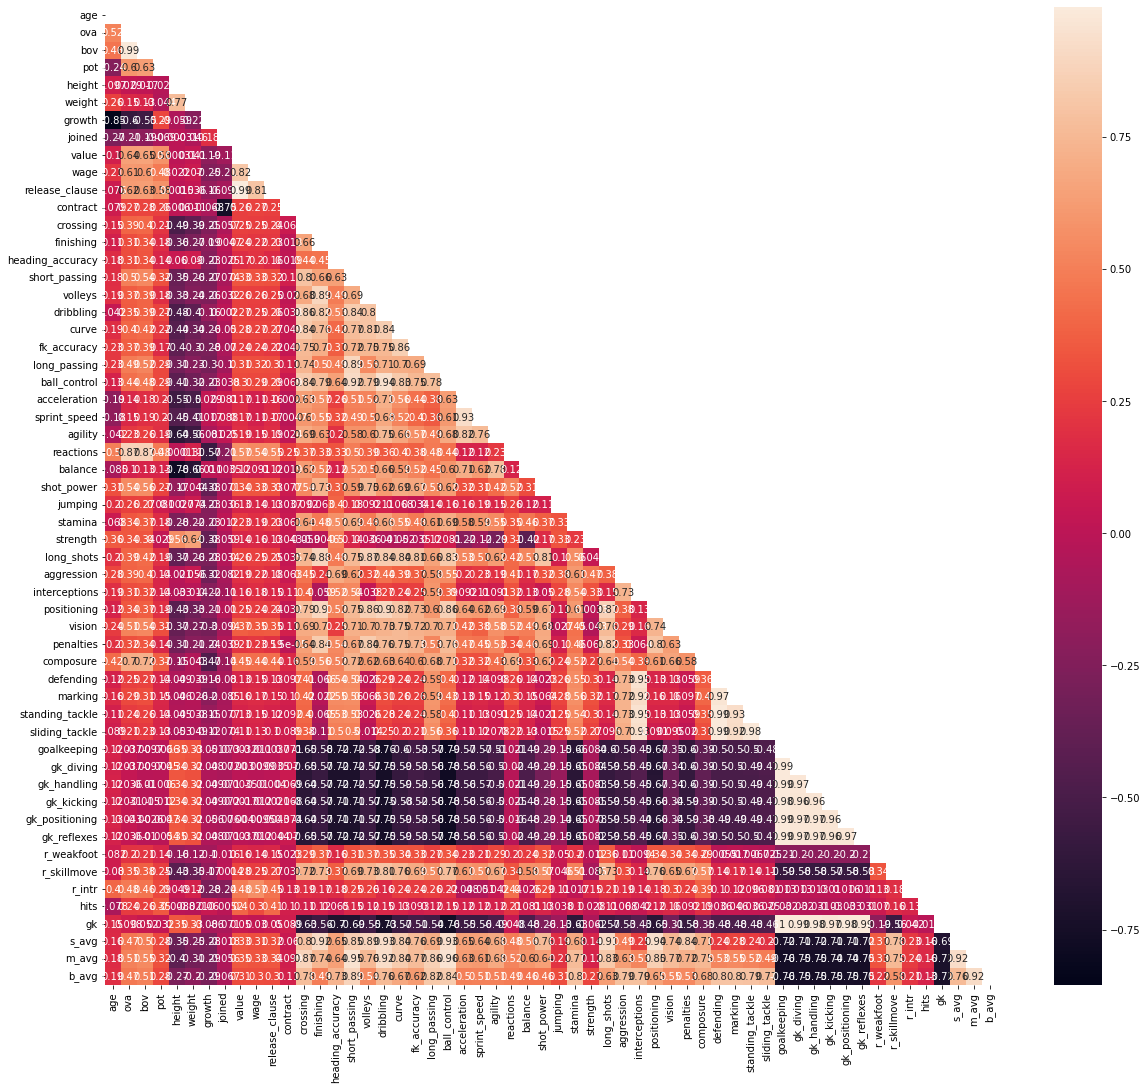

In [ ]:
# heatmap for data including individual attributes

mask = np.zeros_like(data_att.corr())

mask[np.triu_indices_from(mask)] = True 

fig, ax = plt.subplots(figsize=(20, 18))
ax = sns.heatmap(data_att.corr(), mask=mask, annot=True)
plt.show()

In [ ]:
data_umb.dtypes

age                 int64
ova                 int64
bov                 int64
pot                 int64
height              int64
weight              int64
growth              int64
joined              int64
value               int64
wage                int64
release_clause      int64
contract            int64
attacking           int64
skill               int64
movement            int64
power               int64
mentality           int64
defending           int64
goalkeeping         int64
total_stats         int64
base_stats          int64
r_weakfoot          int64
r_skillmove         int64
r_intr              int64
pac                 int64
sho                 int64
pas                 int64
dri                 int64
def                 int64
phy                 int64
hits                int64
gk                  int64
pac_stdev         float64
sho_stdev         float64
pas_stdev         float64
dri_stdev         float64
def_stdev         float64
phy_stdev         float64
gk_stdev    

# 5 Processing Data

#### | Baseline model |

initial modeling to compare with coming models after data changes (transformations, encoding, ...)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# define the features and target variable
X = data_umb.drop(['value'], axis=1)
y = data_umb['value']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# make predictions on the testing set
y_pred = model_lr.predict(X_test)

# evaluate the model using mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)


Mean Squared Error: 411171863681.709
R-squared: 0.9848992236403613


In [ ]:
coef = model_lr.coef_
print(coef)

[-3.46087646e+04  3.29659751e+04 -1.23473431e+04  5.71285180e+03
 -8.09561168e+02 -2.71411826e+02 -2.72531236e+04 -4.90349406e+04
  1.22209767e+01  4.77496363e-01 -4.43446418e+04 -1.30809528e+03
 -2.21814460e+03  5.10570121e+02  6.49459924e+02 -4.99871379e+02
 -5.34795095e+02  3.58914185e+03  1.88265549e+02 -2.34476063e+02
  4.10578103e+03  1.62258280e+04  3.71140702e+05  2.05196119e+02
 -1.34262290e+03  6.90329225e+03 -3.70854453e+03 -3.69447186e+03
  1.40267485e+03 -2.53855990e+02 -2.11239649e+04  5.76971214e+03
 -5.25538113e+03 -9.19928731e+03 -3.24893384e+02  7.04541402e+02
  1.37880805e+03  2.92318089e+04  1.59240969e+04]


In [ ]:

# Create a dataframe with the actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the first 10 rows
print(results.head(10))


        Actual     Predicted
8879   4900000  5.023014e+06
206     650000  6.747707e+05
7044   2300000  1.542674e+06
7005   4700000  4.432522e+06
7823   4000000  3.142790e+06
16499   525000  6.682240e+05
16334   750000  6.470549e+05
2498    475000  6.161335e+05
114    3000000  1.962756e+06
802    2100000  2.278972e+06


In [ ]:
from sklearn.metrics import confusion_matrix
 
results = confusion_matrix(y_test, y_pred)
print(results)

ValueError: ignored

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_umb.drop('value', axis=1), data_umb['value'], test_size=0.3, random_state=42)

# Create and fit a decision tree regression model
model_dt = DecisionTreeRegressor(max_depth=5, random_state=42)
model_dt.fit(X_train, y_train)

# Predict on the test set
y_pred = model_dt.predict(X_test)

# Evaluate the model using the mean absolute error (MAE)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")


Mean Absolute Error: 379428.94


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_umb.drop('value', axis=1), data_umb['value'], test_size=0.3, random_state=42)

# Create and fit a random forest regression model
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)

# Predict on the test set
y_pred = model_rf.predict(X_test)

# Evaluate the model using the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest Mean Absolute Error: {mae:.2f}")

# Compare to the linear regression model
lr_mae = mean_absolute_error(y_test, model_lr.predict(X_test))
print(f"Linear Regression Mean Absolute Error: {lr_mae:.2f}")

# Compare to the decision tree regression model
dt_mae = mean_absolute_error(y_test, model_dt.predict(X_test))
print(f"Decision Tree Regression Mean Absolute Error: {dt_mae:.2f}")


Random Forest Mean Absolute Error: 207872.55
Linear Regression Mean Absolute Error: 333673.97
Decision Tree Regression Mean Absolute Error: 379428.94


In [ ]:
def predict_value(df, lr_model, dt_model, rf_model):
    # Separate the target variable from the features
    X = data_umb.drop('value', axis=1)
    y = data_umb['value']

    # Make predictions using each model
    lr_pred = model_lr.predict(X)
    dt_pred = model_dt.predict(X)
    rf_pred = model_rf.predict(X)

    # Add the predictions to the dataframe
    df['LR_Predicted_Value'] = lr_pred
    df['DT_Predicted_Value'] = dt_pred
    df['RF_Predicted_Value'] = rf_pred

    # Sort the dataframe by predicted value
    df = df.sort_values(by='RF_Predicted_Value', ascending=False)
    return df[['Name', 'LR_Predicted_Value', 'DT_Predicted_Value', 'RF_Predicted_Value', 'value']]



In [ ]:
# Linear regression model
lr_pred = model_lr.predict(X_test)
print("Linear Regression Predictions:")
print(lr_pred)

# Decision tree regression model
dt_pred = model_dt.predict(X_test)
print("Decision Tree Regression Predictions:")
print(dt_pred)

# Random forest regression model
rf_pred = model_rf.predict(X_test)
print("Random Forest Regression Predictions:")
print(rf_pred)


Linear Regression Predictions:
[5023013.75295174  674770.74359091 1542673.97383913 ... 3521134.38580304
 4536843.72634421 8206293.24402422]
Decision Tree Regression Predictions:
[5422330.09708738 1110581.83376178 1110581.83376178 ... 3637825.05910165
 5422330.09708738 8297142.85714286]
Random Forest Regression Predictions:
[5345272.08811663  790289.24691995 1968834.30330694 ... 3401150.65200828
 5435699.78743034 8096710.73495205]


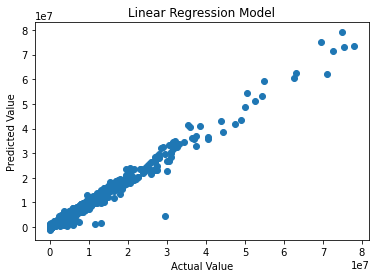

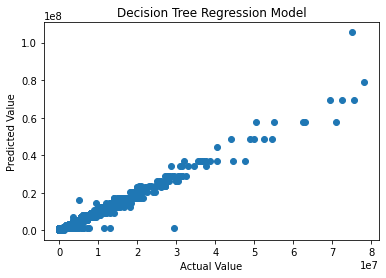

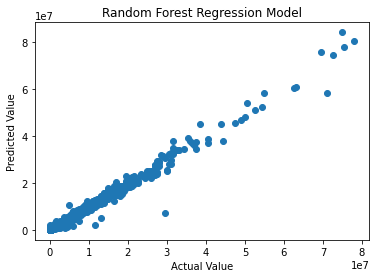

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of the actual versus predicted market values for the linear regression model
plt.scatter(y_test, lr_pred)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Linear Regression Model")
plt.show()

# Create a scatter plot of the actual versus predicted market values for the decision tree regression model
plt.scatter(y_test, dt_pred)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Decision Tree Regression Model")
plt.show()

# Create a scatter plot of the actual versus predicted market values for the random forest regression model
plt.scatter(y_test, rf_pred)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Random Forest Regression Model")
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the RMSE and R-squared for the linear regression model
lr_rmse = mean_squared_error(y_test, lr_pred, squared=False)
lr_r2 = r2_score(y_test, lr_pred)
print("Linear Regression Model")
print("RMSE:", lr_rmse)
print("R-squared:", lr_r2)

# Calculate the RMSE and R-squared for the decision tree regression model
dt_rmse = mean_squared_error(y_test, dt_pred, squared=False)
dt_r2 = r2_score(y_test, dt_pred)
print("Decision Tree Regression Model")
print("RMSE:", dt_rmse)
print("R-squared:", dt_r2)

# Calculate the RMSE and R-squared for the random forest regression model
rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
rf_r2 = r2_score(y_test, rf_pred)
print("Random Forest Regression Model")
print("RMSE:", rf_rmse)
print("R-squared:", rf_r2)


Linear Regression Model
RMSE: 766692.600993174
R-squared: 0.9814425887481553
Decision Tree Regression Model
RMSE: 978805.7514088835
R-squared: 0.9697540051938723
Random Forest Regression Model
RMSE: 649596.1024661826
R-squared: 0.9866782380431297


Based on the Root Mean Squared Error (RMSE) and R-squared values, it seems that the Random Forest Regression Model is performing better than the other two models. The RMSE value for the Random Forest Regression Model is the lowest, indicating that it is making more accurate predictions of player market values. Additionally, the R-squared value for the Random Forest Regression Model is the highest, indicating that it is explaining more of the variance in the target variable.

However, it's important to note that there may be other factors to consider when selecting the best model for this dataset, such as computational complexity and interpretability.